# Práctica 5

Alumno: Zhengkai Zhu

In [27]:
import sys
print(sys.version)

3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]


In [28]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings("ignore")
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
import math


In [29]:
def simulate_QASM(qc, shots):
    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend = backend, optimization_level= 1)
    job = backend.run(tqc, shots = shots)
    result = job.result()
    counts = result.get_counts()

    display(plot_histogram(counts))

Funcion sencilla que me permite simular el circuito que recibe como parametro y mostrar los resultados de medicion con tantos shots como indica el parámetro correspondiente. Esto me permite no copiar y pegar el mismo código en numerosas celdas

## Ejercicio 1

En este ejercicio se nos pide implementar dos funciones constantes y dos funciones balanceadas para 2, 3 y 4 qubits.\
Las funciones constantes son iguales para cualquier cantidad de qubits.\
Por lo tanto voy a crear dos funciones que me permiten crear dos oraculos para la $f_0$ la funcion constante 0 y $f_1$ la funcion constante 1.



In [30]:
def dj_circuit(n, oracle):
    qreg = QuantumRegister(n + 1, 'qreg')
    creg = ClassicalRegister(n, 'creg')

    qc = QuantumCircuit(qreg, creg)

    qc.x(n) #Cambiamos el estado del qubit de ancilla a 1

    qc.h(qreg[:]) #Superponemos todos los qubits

    qc.barrier()

    qc.append(oracle, qreg[:]) #Aplicamos el oraculo correspondiente
    
    qc.barrier()

    qc.h(qreg[:n]) #Volvemos a aplicar la Hadamard sobre los qubits de datos

    qc.measure(qreg[:n], creg[:]) #Finalmente medimos los qubits de datos
    
    return qc

Como la construccion del circuito para implementar el algoritmo de Deutsch-Jozsa es el igual sin importar el numero de qubits, pues creo una funcion que recibe el numero de qubits y el oraculo, y me implemente el circuito.

Al final es solo:
1. Aplicar una $X$ en el qubit de ancilla.
2. Aplicar puertas $H$ a todos los qubits.
3. Aplicar el oraculo.
4. Aplicar puertas $H$ en los qubits de datos.
5. Finalmente medir los qubits de datos.

##### Funcion: $f_0$



$$f_0:\{0,1\}^{n} \rightarrow \{0,1\} $$

Tal que $f_0(x) = 0$ $\forall x \in \{0,1\}^{n}$

Para este caso, el oráculo es un oráculo sin nada. Este oráculo debería ser la identidad, que deja el estado del circuito tal cual está.\
Con tal de hacer algo y que el oráculo no quede vacío

In [31]:
def oracle_f0(n):
    ret = QuantumCircuit(n + 1, name = 'oracle_f0')
    ret.id(n)
    
    return ret

##### Funcion: $f_1$

$$f_1:\{0,1\}^{n} \rightarrow \{0,1\} $$

Tal que $f_1(x) = 1$ $\forall x \in \{0,1\}^{n}$

In [32]:
def oracle_f1(n):
    ret = QuantumCircuit(n + 1, name = 'oracle_f1')
    ret.x(n)
    
    return ret

Otra manera de implementar la función sería de la siguiente manera

In [33]:
def oracle_f1_2(n):
    ret = QuantumCircuit(n + 1, name = 'oracle_f1')
    for i in range(n):
        ret.cx(i, n)
        ret.x(i)
        ret.cx(i, n)
    
    if (n % 2) == 0: #Si n es par, habremos aplicado una cantidad par de cx sobre el qubit n, al final quedaría igual.
        ret.x(n)
    
    return ret
        

#Este es el tipo de oraculo constantemente 1 que aparece en los apuntes de la asignatura.

Ejemplo:

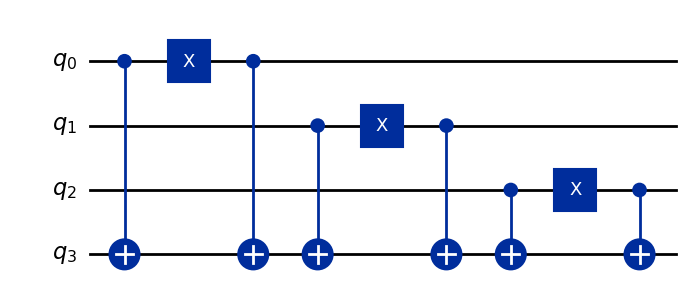

In [34]:
prueba = oracle_f1_2(3)

display(prueba.draw('mpl'))

Este es el oraculo que aparece en los apuntes del Tema 4 sobre el algoritmo de Deutsch-Jozsa. 

Pero para todos los casos, voy a utilizar la funcion más simple, para evitar aumentar la complejidad del circuito

### Caso: 2 qubits 

In [35]:
n = 2

En esta parte voy a implementar los oráculos para funciones de 2 bits de entrada.\
Específicamente voy a implementar dos funciones constantes y dos funciones balanceadas.

Creo el oraculo para la funcion constante $f_0$

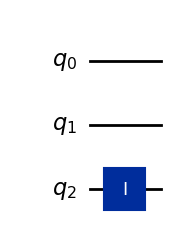

In [36]:
ora2f0 = oracle_f0(n)
display(ora2f0.draw('mpl'))

Creo el oraculo para la funcion constante $f_1$

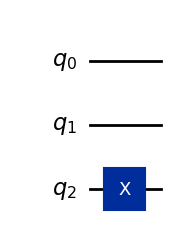

In [37]:
ora2f1 = oracle_f1(n)

display(ora2f1.draw('mpl'))

A continuacion voy a crear las dos funciones balanceadas

#### Funcion $f_{b1_{2bits}}$ 
(b1 de balanceada 1)

$$f_{b1}:\{0,1\}^{2} \rightarrow \{0,1\} $$

Para empezar, voy a implementar el oraculo de una funcion balanceada sencilla y poco a poco voy aumentando la complejidad de las funciones.

$f_{b1}(\ket{01}) = 1$\
$f_{b1}(\ket{11}) = 1$ 

El resto se quedan en 0. Es una funcion que devuelve 1 cuando el ultimo bit de entrada esta a 1.\
Al final es simplemente una $CNOT$ con el qubit menos significativo como control y luego el qubit de ancilla como target. 

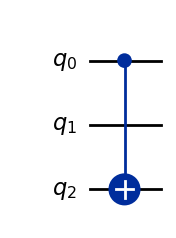

In [38]:
ora2fb1 = QuantumCircuit(n + 1, name = 'oracle_fb1')

ora2fb1.cx(0, n)

display(ora2fb1.draw('mpl'))

#### Funcion $f_{b2_{2bits}}$ 

Para esta segunda función:
$$f_{b2}:\{0,1\}^{2} \rightarrow \{0,1\} $$

Va a ser de la siguiente manera:
- $f_{b2}(\ket{00}) = 1$
- $f_{b2}(\ket{11}) = 1$

Este caso es algo más compleja y ya no es simplemente aplicar una CNOT. 

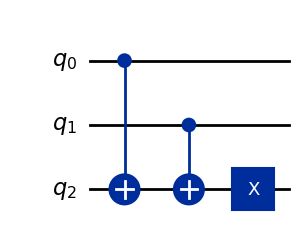

In [39]:
ora2fb2 = QuantumCircuit(n + 1, name = 'oracle_fb2')

ora2fb2.cx(0, n)
ora2fb2.cx(1, n) 
ora2fb2.x(n)

display(ora2fb2.draw('mpl'))

Si las dos CNOTS se activan a la vez o ninguna se activa, cambiamos el signo con la X.\
Así hacemos que sea un oráculo de la funcion que devuelva 1 cuando tenemos $\ket{00}$ y $\ket{11}$.
Si solo se activa uno de ellos, devolvemos el qubit 2 a su estado original con una X

##### Una vez implementado los oraculos para funciones de 2 bits de entrada, vamos a probarlos

##### 1. $f_0(x)$

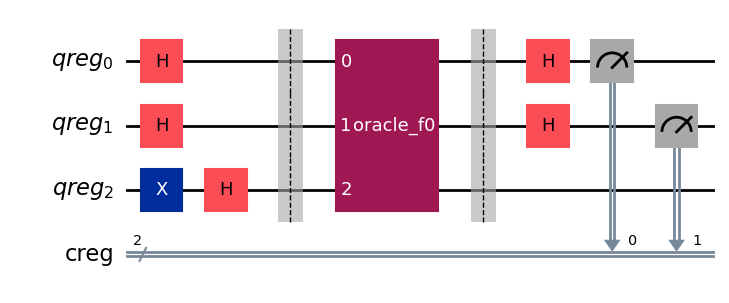

In [40]:
qc = dj_circuit(n, ora2f0) 
display(qc.draw('mpl'))

Ahora vamos a ver la simulacion a ver qué obtenemos

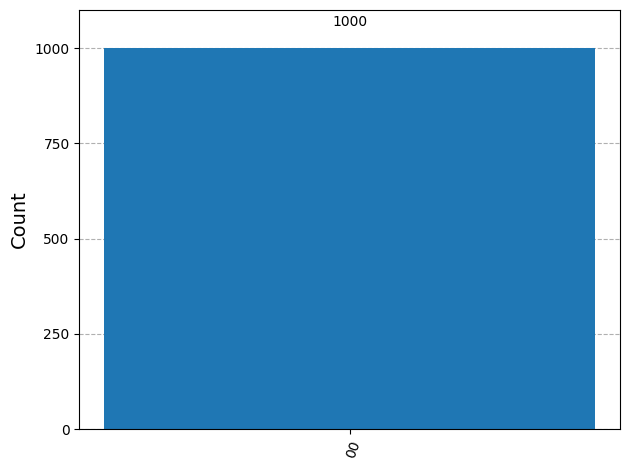

In [41]:
simulate_QASM(qc, 1000)

Es una funcion constante y hemos obtenido un valor 0 al medir, por tanto, el algoritmo de Deutsch-Jozsa ha funcionado correctamente

##### 2. $f_1(x)$

Ahora probamos para la otra funcion constante que tenemos

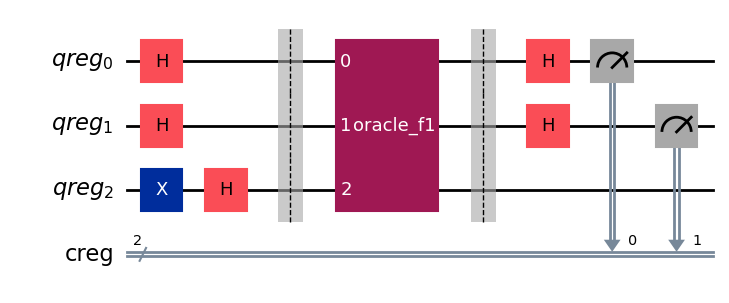

In [42]:
qc = dj_circuit(n, ora2f1) 
display(qc.draw('mpl'))

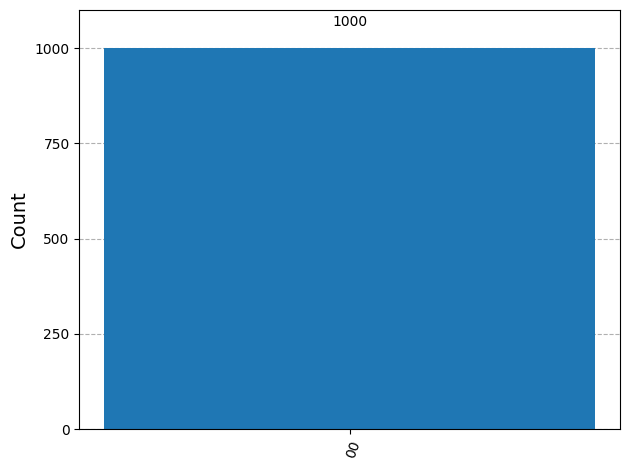

In [43]:
simulate_QASM(qc, 1000)

Al igual que el otro caso de funcion constante, hemos obtenido el mismo valor 0, que indica que es constante

##### 3. $f_{b1_{2bits}}(x)$

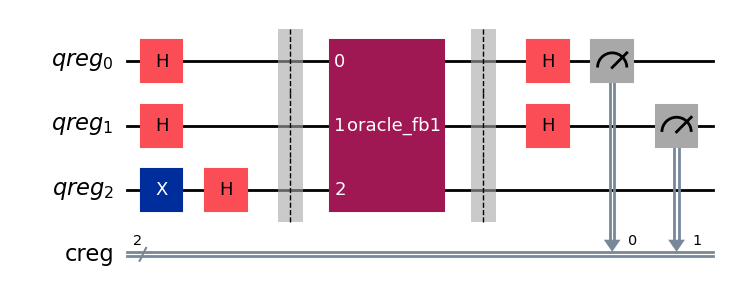

In [44]:
qc = dj_circuit(n, ora2fb1) 
display(qc.draw('mpl'))

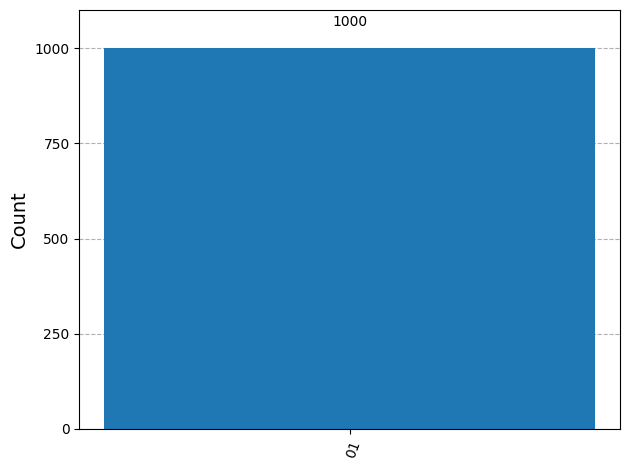

In [45]:
simulate_QASM(qc, 1000)

##### 4. $f_{b2_{2bits}}(x)$

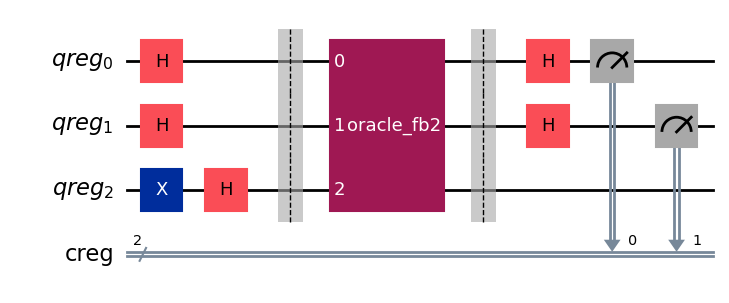

In [46]:
qc = dj_circuit(n, ora2fb2) 
display(qc.draw('mpl'))

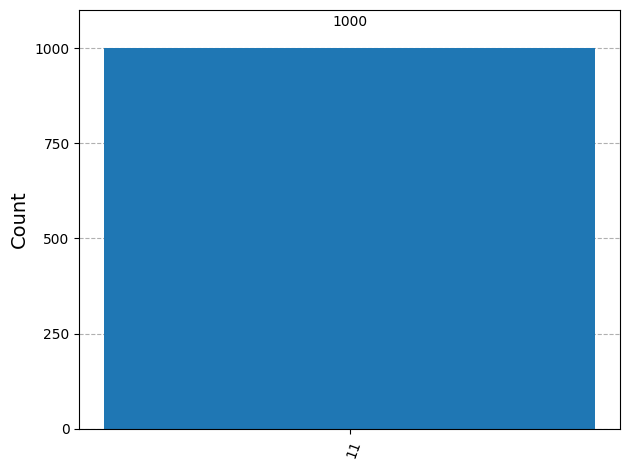

In [47]:
simulate_QASM(qc, 1000)

En ambas funciones balanceadas que he implementado, al aplicar el algoritmo de Deutsch-Jozsa obtengo dos valores distintos de 0, por lo tanto, nos demuestra que son balanceadas.

### Caso: 3 qubits 

In [53]:
n = 3

Creo el oraculo para la funcion $f_0$

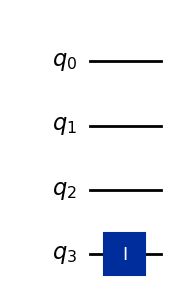

In [ ]:
ora3f0 = oracle_f0(n)

display(ora3f0.draw('mpl'))

Creo el oraculo para la funcion $f_1$

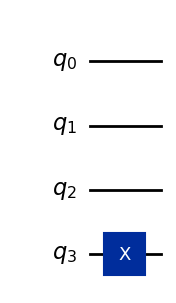

In [ ]:
ora3f1 = oracle_f1(n)

display(ora3f1.draw('mpl'))

A partir de aqui voy a implementar los oraculos para funciones balanceadas

#### Funcion $f_{b1_{3bits}}$ 

Voy a utilizar un ejemplo utilizado en las diapositivas de clase:
$$f_{b1}: \{0,1\}^{3} \rightarrow \{0,1\}$$

Tal que:

$f_{b1}(x) = 1$ si $x \in \{010, 100, 101, 111\}_{(2)}$

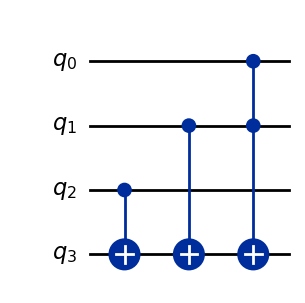

In [54]:
ora3fb1 = QuantumCircuit(n + 1, name = 'oracle_fb1')

ora3fb1.cx(2, n)
ora3fb1.cx(1, n)
ora3fb1.ccx(0, 1, n) #Puerta toffoli al final

display(ora3fb1.draw('mpl'))

- La $CNOT$ controlada por $q_2$ hace que se active $\forall x \in \{100, 101, 110, 111\}_{(2)}$
- La $CNOT$ controlada por $q_1$ hace que se active $\forall x \in \{010, 011, 110, 111\}_{(2)}$
- La $Toffoli$ controlada por $q_0$ y $q_1$ hace que se active para $\forall x \in \{011, 111\}_{(2)}$

De todos estos valores unicamente para $\{010, 100, 101, 111\}_{(2)}$ se activan un numero impar de veces las puertas $NOT$, y así obtenemos el oraculo para la función que hemos definido arriba.

#### Funcion $f_{b2_{3bits}}$ 

$$f_{b2}: \{0,1\}^{3} \rightarrow \{0,1\}$$

Tal que:

$f_{b2}(x) = 1$ si $x \in \{010, 101, 110, 111\}_{(2)}$

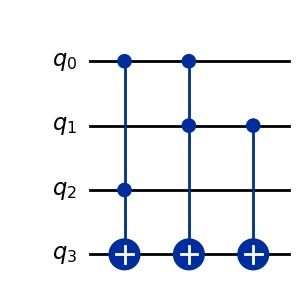

In [55]:
ora3fb2 = QuantumCircuit(n + 1, name = 'oracle_fb1')


ora3fb2.ccx(0, 2, n)
ora3fb2.ccx(0, 1, n)
ora3fb2.cx(1, n)

display(ora3fb2.draw('mpl'))

- La $Toffoli$ controlada por $q_0$ y $q_2$ hace que se active para $\forall x \in \{101, 111\}_{(2)}$
- La $Toffoli$ controlada por $q_0$ y $q_1$ hace que se active para $\forall x \in \{011, 111\}_{(2)}$
- La $CNOT$ controlada por $q_1$ hace que se active $\forall x \in \{010, 011, 110, 111\}_{(2)}$


De todos estos valores unicamente para $\{010, 101, 110, 111\}_{(2)}$ se activan un numero impar de veces las puertas $NOT$, y así obtenemos el oraculo para la función que hemos definido arriba.

##### Una vez implementado los oraculos para funciones de 3 bits de entrada, vamos a probarlos

#### 1. $f_{0_{3bits}}(x)$

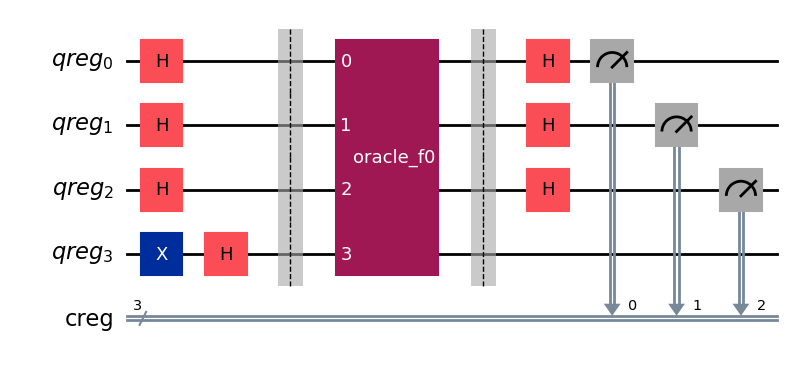

In [56]:
qc = dj_circuit(n, ora3f0)
display(qc.draw('mpl'))

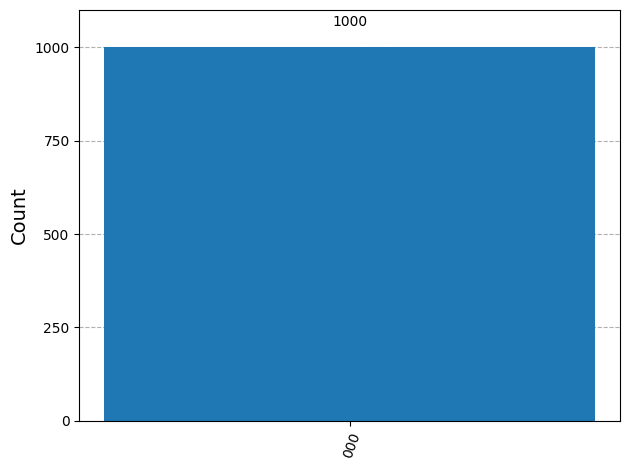

In [57]:
simulate_QASM(qc, 1000)

#### 2. $f_{1_{3bits}}(x)$

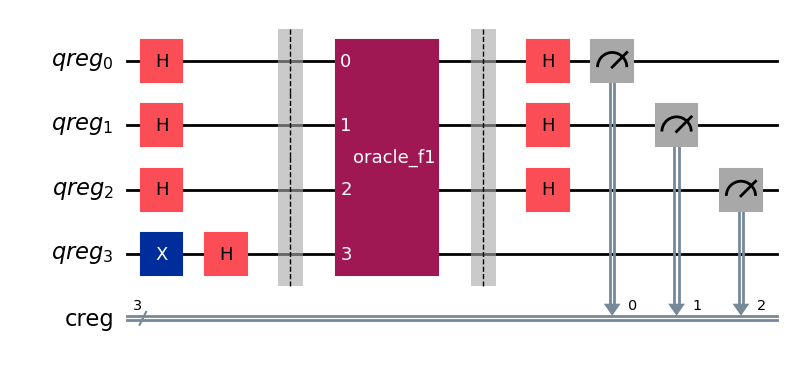

In [58]:
qc = dj_circuit(n, ora3f1)
display(qc.draw('mpl'))

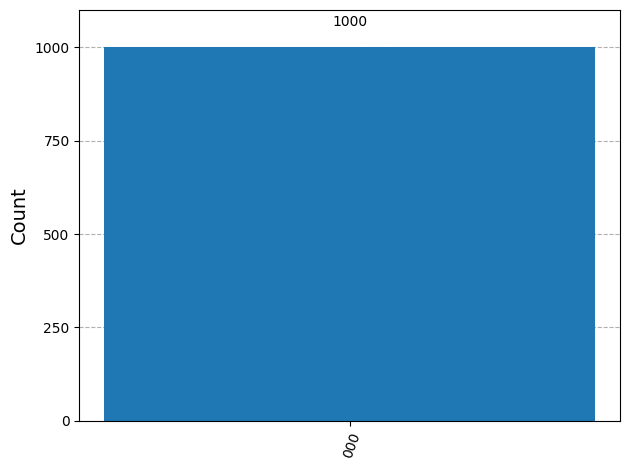

In [59]:
simulate_QASM(qc, 1000)

#### 3. $f_{b1_{3bits}}(x)$

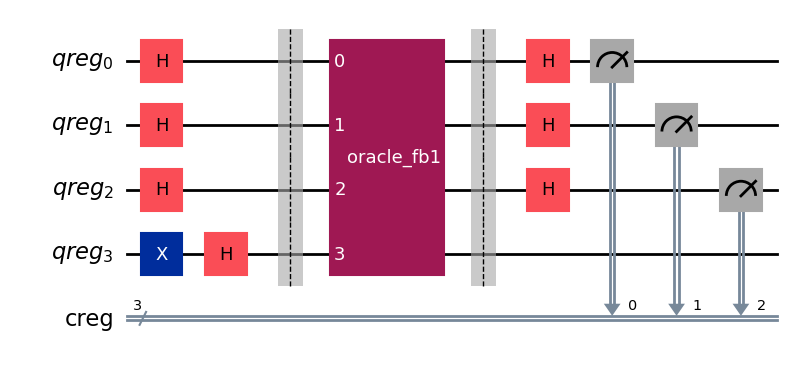

In [60]:
qc = dj_circuit(n, ora3fb1)
display(qc.draw('mpl'))

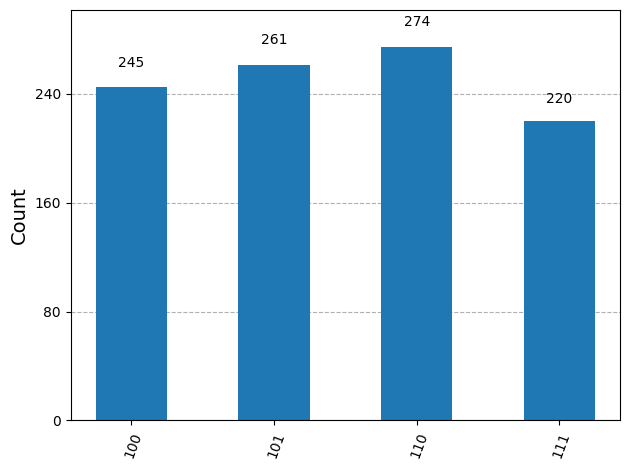

In [61]:
simulate_QASM(qc, 1000)

En este caso, no obtenemos un valor concreto en las mediciones. Esto nos indica que el stateVector no ha acabado en un solo estado propio, sino en una superposición de estos 4.\
No obstante, en ninguna de las mediciones hemos obtenido el valor $\ket{000}$ que es lo necesario en el algoritmo de Deutsch-Jozsa para saber que la funcion es balanceada.

#### 4. $f_{b2_{3bits}}(x)$

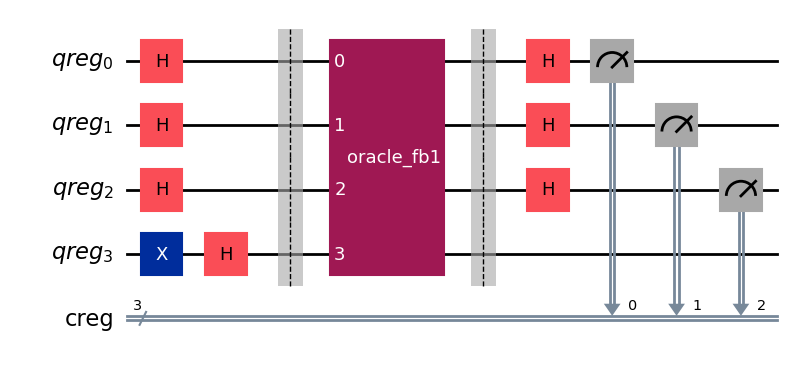

In [62]:
qc = dj_circuit(n, ora3fb2)

display(qc.draw('mpl'))

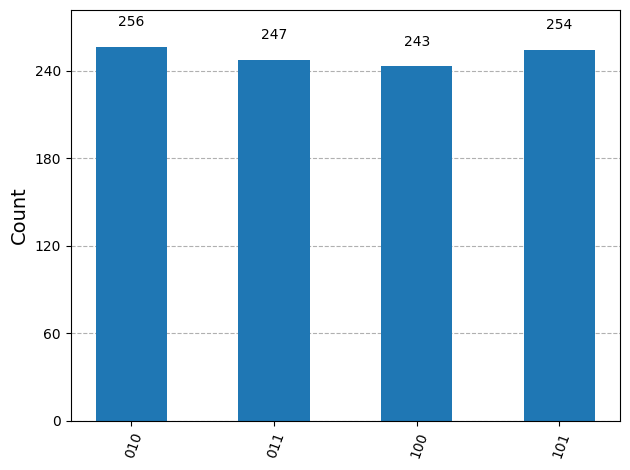

In [63]:
simulate_QASM(qc, 1000)

En este caso que hemos usado una función balanceada también hemos obtenido unos valores de medición distintos a 0. Por lo tanto, queda demostrado que es una función balanceada nuestra $f_{b2_{3bits}}$

### Caso: 4 qubits 

En esta seccion voy a implementar el algoritmo de Deutsch-Jozsa para funciones de 4 bits de entrada

In [67]:
n = 4

Creo el oraculo para la funcion $f_0$

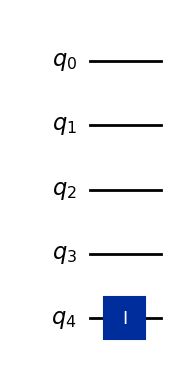

In [68]:
ora4f0 = oracle_f0(n)
display(ora4f0.draw('mpl'))

Creo el oraculo para la funcion $f_1$

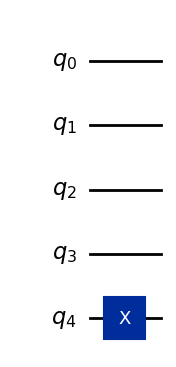

In [69]:
ora4f1 = oracle_f1(n)
display(ora4f1.draw('mpl'))

#### Funcion $f_{b1_{4bits}}$ 

$$f_{b1}: \{0,1\}^{4} \rightarrow \{0,1\}$$

Este va a ser una función sencilla balanceada tal que:

$f_{b1}(x) = 1$ si $x \in \{0010, 0011, 0100, 0101, 1000, 1001, 1110, 1111\}_{(2)}$

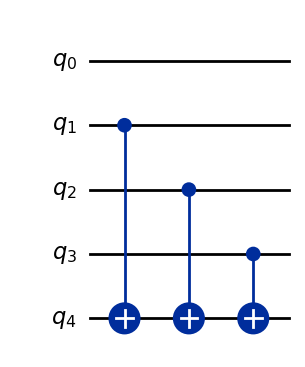

In [ ]:
ora4fb1 = QuantumCircuit(n + 1, name = 'oracle4_fb1')

ora4fb1.cx(1, n)

ora4fb1.cx(2, n)

ora4fb1.cx(3, n)

display(ora4fb1.draw('mpl'))

- La $CNOT$ con control en $q_3$ permite que se active para los valores $\{1000, 1001, 1010, 1011, 1100, 1101, 1110, 1111\}_{(2)}$
- La $CNOT$ con control en $q_2$ permite que se active para los valores $\{0100, 0101, 0110, 0111, 1100, 1101, 1110, 1111\}_{(2)}$
- La $CNOT$ con control en $q_1$ permite que se active para los valores $\{0010, 0011, 0110, 0111, 1010, 1011, 1110, 1111\}_{(2)}$

Entonces los valores para las cuales se activan un numero impar de veces la $CNOT$ son: $\{0010, 0011, 0100, 0101, 1000, 1001, 1110, 1111\}_{(2)}$ que son los valores para los cuales la función devuelve 1

#### Funcion $f_{b2_{4bits}}$

$$f_{b1}: \{0,1\}^{4} \rightarrow \{0,1\}$$

Este va a ser una función sencilla balanceada tal que:

$f_{b1}(x) = 1$ si $x \in C=\{0000, 0001, 0110, 0111, 1000, 1011, 1101, 1110\}_{(2)}$

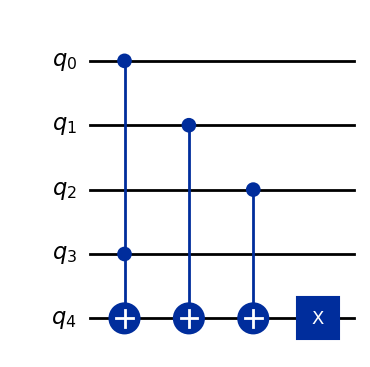

In [72]:
ora4fb2 = QuantumCircuit(n + 1, name = 'oracle4_fb1')

ora4fb2.ccx(0, 3, n)

ora4fb2.cx(1, n)

ora4fb2.cx(2, n)

ora4fb2.x(n)

display(ora4fb2.draw('mpl'))

- La $Toffoli$ con control en $q_3$ y $q_0$ permite que se active para los valores $\{1001, 1011, 1101, 1111\}_{(2)}$
- La $CNOT$ con control en $q_2$ permite que se active para los valores $\{0100, 0101, 0110, 0111, 1100, 1101, 1110, 1111\}_{(2)}$
- La $CNOT$ con control en $q_1$ permite que se active para los valores $\{0010, 0011, 0110, 0111, 1010, 1011, 1110, 1111\}_{(2)}$

Esto nos permite crear un oráculo para una funcion que devuelve 1 para las entradas:
$x \in C' =\{0010, 0011, 0100, 0101, 1001, 1010, 1100, 1111\}_{(2)}$

Tenemos que $C = \{0, 1\}^{4} \setminus C'$. De ahí que he puesto una X al final, para que se active cuando no se haya activado antes un numero impar de veces.

#### 1. $f_{0_{4bits}}(x)$

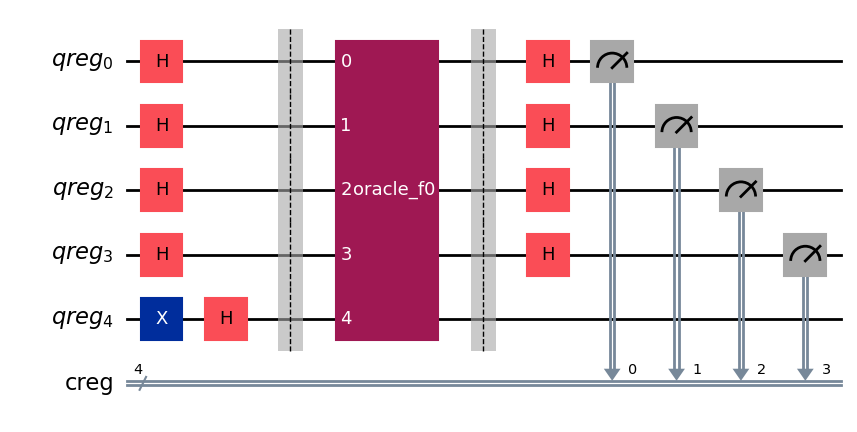

In [73]:
qc = dj_circuit(n, ora4f0)
display(qc.draw('mpl'))

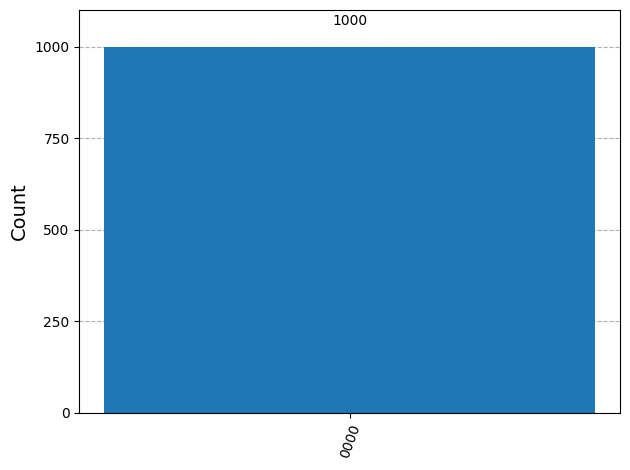

In [74]:
simulate_QASM(qc, 1000)

#### 2. $f_{1_{4bits}}(x)$

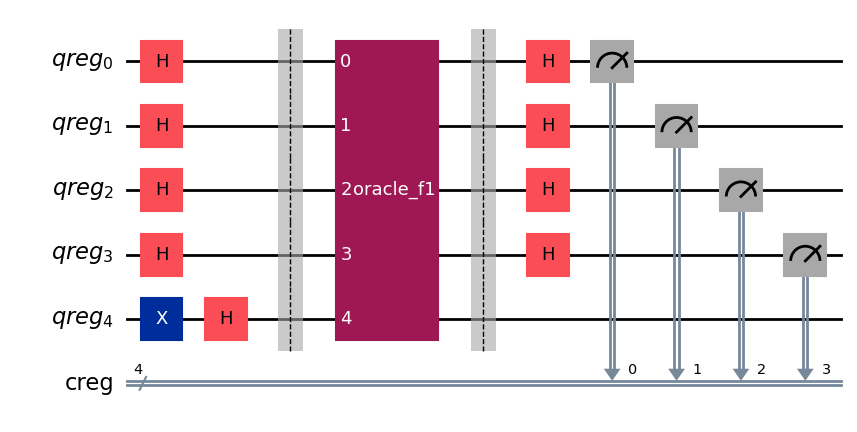

In [77]:
qc = dj_circuit(n, ora4f1)
display(qc.draw('mpl'))

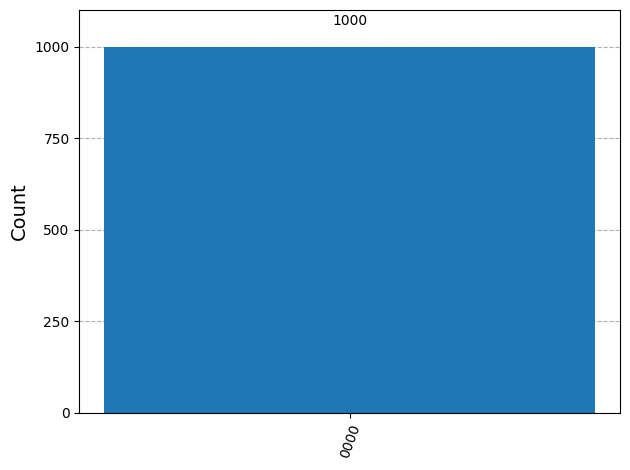

In [78]:
simulate_QASM(qc, 1000)

En estos dos casos de funciones constantes, volvemos a obtener 0 al final en la medicion.\
El circuito para ejecutar el algoritmo de Deutsch-Jozsa ha funcionado correctamente y hemos obtenido 0 al final lo que indica que son funciones contantes.

#### 3. $f_{b1_{4bits}}(x)$

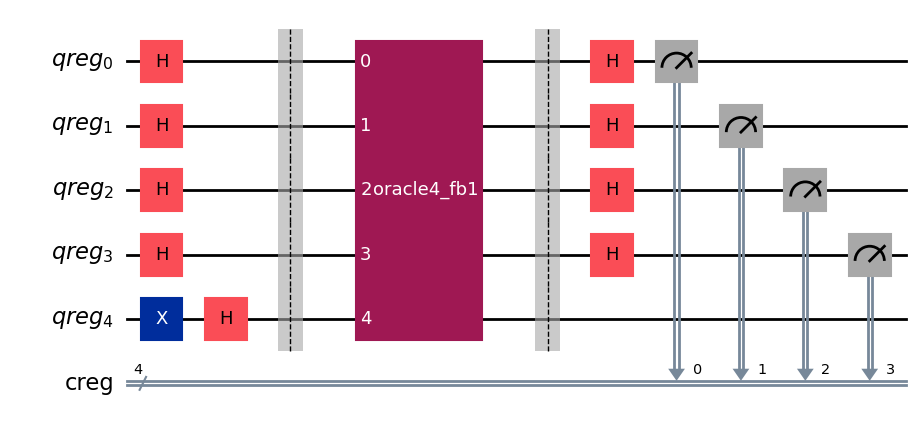

In [79]:
qc = dj_circuit(n, ora4fb1)
display(qc.draw('mpl'))

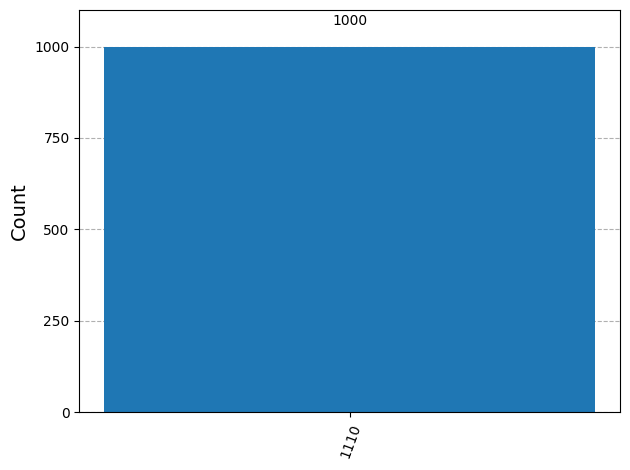

In [80]:
simulate_QASM(qc, 1000)

#### 4. $f_{b2_{4bits}}(x)$

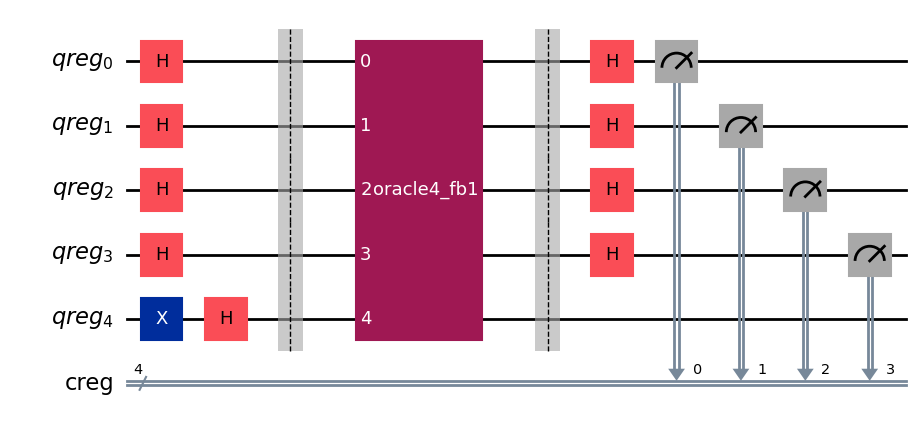

In [81]:
qc = dj_circuit(n, ora4fb2)
display(qc.draw('mpl'))

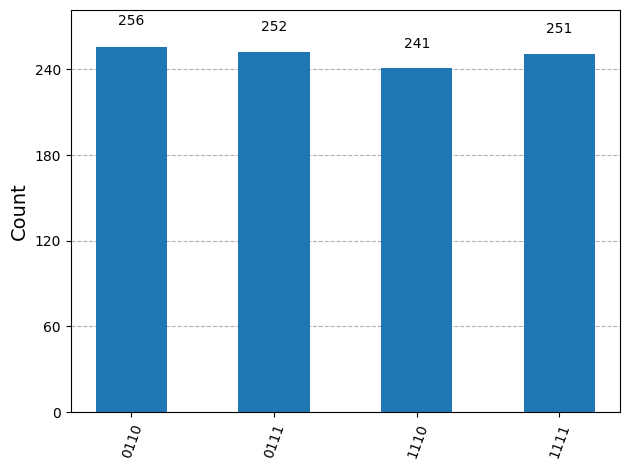

In [82]:
simulate_QASM(qc, 1000)

En estos ultimos dos casos de funciones balanceadas hemos obtenido resultados variados.\
Para $f_{b1}$ hemos obtenido en las mediciones un $100\%$ de mediciones de $1110_{2}$.\
Por otro lado, para $f_{b2}$ hemos obtenido 4 mediciones diferentes, lo que parece indicar que el stateVector final de los qubits de datos no han acabado en un estado concreto, sino en una superposicion de estos 4. No obstante, ninguno de los 4 estados que se miden son 0.\
Por lo tanto, concluimos que ambas funciones son balanceadas al no obtener 0 en los qubits de datos, lo que demuestra que son funciones balanceadas.

---
### Casos no balanceados ni constantes

En esta seccion voy a tratar 2 funciones que no son ni constantes ni balanceadas para ver qué ocurre con los qubits de datos tras aplicar el algoritmo de Deutsch-Jozsa.
Una de las funciones es para 2 bits de entrada y el otro es para 4 bits de entrada.\
Voy a implementar para ambos casos el algoritmo y al final del todo, voy a explicar qué ocurre.

#### 2 bits

Para 2 bits un oráculo para la siguiente función:
$$f_{a1}: \{0,1\}^{2} \rightarrow \{0,1\}$$ 
tal que: 
- $f_{a1}(11) = 0$

Para el resto de estados la funcion devuelve 1.

La implementacion de un oraculo es simplemente una puerta $Toffoli$ con los dos qubits de datos como controles y la ancilla como objetivo, y luego agregamos al final una $X$

In [150]:
n = 2

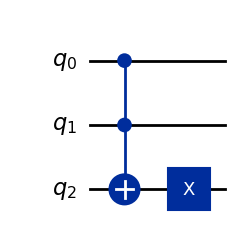

In [151]:
ora2fa1 = QuantumCircuit(n + 1, name = 'oracle_fa1')

ora2fa1.ccx(0, 1, n)
ora2fa1.x(n)

display(ora2fa1.draw('mpl'))

De esta manera cuando ambos qubits de control están a 1, es decir, tenemos $x = (11)_2$, se active la $Toffoli$, pero la $X$ final lo devuelve a su estado original.\
Cuando no se activa, que es con los estados $\ket{00}, \ket{01}, \ket{10}$, la puerta $X$ hace que se cambie 

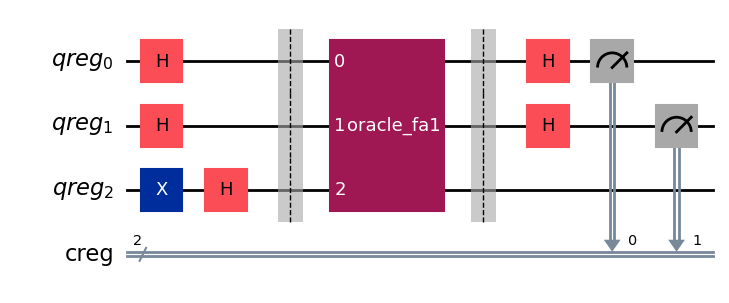

In [152]:
qc = dj_circuit(n, ora2fa1)
display(qc.draw('mpl'))

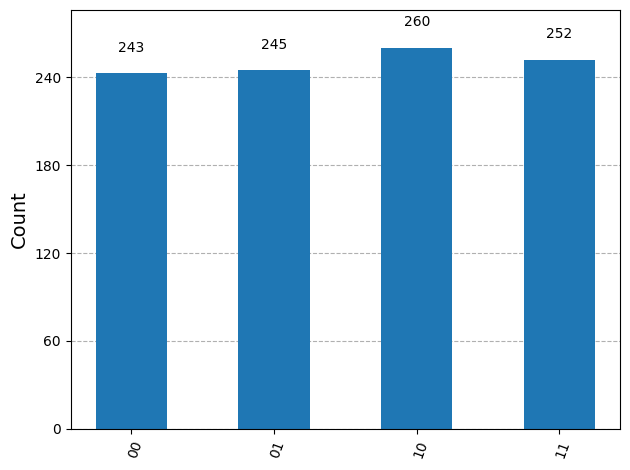

In [156]:
simulate_QASM(qc, 1000)

#### 4 bits

Para 4 bits un oráculo para la siguiente función:
$$f_{a2}: \{0,1\}^{4} \rightarrow \{0,1\}$$ 
Tal que:

$f_{a2}(x) = 1$ si $x \in \{0011, 0110, 1110, 1111\}$\
y el resto devuelve por la salida 0.

In [157]:
n = 4

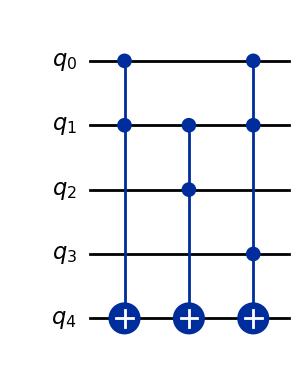

In [176]:
ora4fa2 = QuantumCircuit(n + 1, name = 'oracle_fa2')

ora4fa2.ccx(0, 1, n)
ora4fa2.ccx(1, 2, n)
ora4fa2.mcx([0, 1, 3], n) #Con esta funcion me permite crear una toffoli con le numero de controles que quiera

display(ora4fa2.draw('mpl'))

Explicación:
- La $Toffoli$ con controles en $q_0$ y $q_1$ se activa para los valores $\{0011, 0111, 1011, 1111\}_{(2)}$
- La $Toffoli$ con controles en $q_0$ y $q_1$ se activa para los valores $\{0110, 0111, 1110, 1111\}_{(2)}$
- La puerta $C^{3}NOT$ con controles en $q_0$ y $q_1$ y $q_3$ se activa para los valores $\{1011, 1111\}_{(2)}$

Por lo tanto, los valores para los cuales se activan un numero impar de $NOTs$ son los del conjunto: $\{0011, 0110, 1110, 1111\}_{(2)}$. Estos son los valores para los cuales la función devuelve 1.

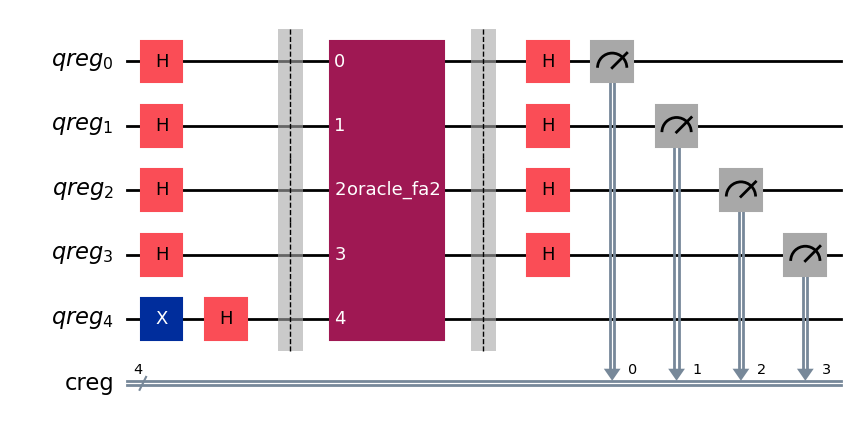

In [177]:
qc = dj_circuit(n, ora4fa2)

display(qc.draw('mpl'))

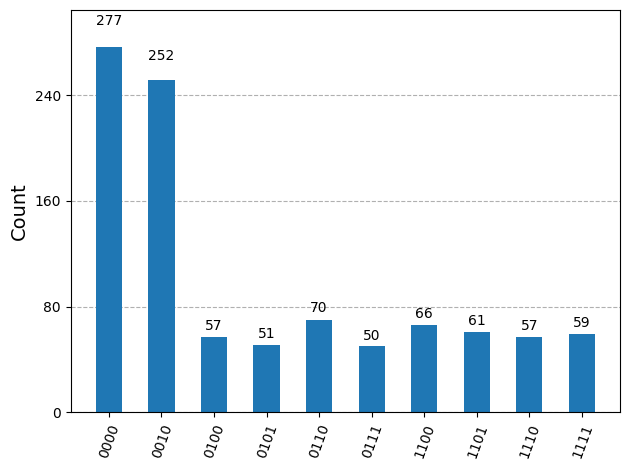

In [178]:
simulate_QASM(qc, 1000)

#### Explicación

Después de simular ambos el algoritmo para estos dos tipos de funciones que no son ni balanceadas ni constantes, vemos que el estado final del los qubits es una superposición de estados.\
Lo que más destaca de esta superposición es que se llega a medir el estado $\ket{0}$ y a la vez también otros valores distintos de $\ket{0}$.\
Pero, ¿por qué ocurre esto?
- Sabemos para empezar que si la función es constante siempre mediremos $\ket{0}$, es decir, la probabilidad de obtener este estado es del $100\%$.
- Si la función no es constante, pero es balanceada, es decir, para la mitad de los valores del dominio devuelve 0 y para la otra mitad devuelve 1.\
En este caso, el estado final que deja el circuito del algoritmo es un estado en el que $\ket{0}$ tiene amplitud nula, es decir, la probabilidad de medir $\ket{0}$ es del $0\%$.\
Cabe destacar que puede ser un estado propio, o una superposición de estados, pero en ninguno de ellos estará el $\ket{0}$. 

Volviendo a nuestros casos, hemos obtenido una superposición de estados propios donde se incluye también esta $\ket{0}$.


Voy a mostrar todo los pasos por los que pasa los estados del circuito.

0) Estado inicial: 

$$\ket{\psi_{0}} = \ket{0^{\otimes n}}\ket{1}$$

1) Aplico las Hadamard: 

$$\ket{\psi_{1}} = H^{\otimes (n + 1)} (\ket{0^{\otimes n}}\ket{1})$$
$$\ket{\psi_{1}} = \frac{1}{\sqrt{2^{n + 1}}}\sum_{x = 0}^{2^{n} - 1}\ket{x}\left(\ket{0} - \ket{1}\right)$$


2) Oráculo: 

$$\ket{\psi_{2}} = \frac{1}{\sqrt{2^{n + 1}}}\sum_{x = 0}^{2^{n} - 1}\ket{x}\left(\ket{f(x)} - \ket{1 \oplus f(x)}\right)$$
$$\ket{\psi_{2}} = \frac{1}{\sqrt{2^{n + 1}}}\sum_{x = 0}^{2^{n} - 1}(-1)^{f(x)}\ket{x}\left(\ket{0} - \ket{1}\right)$$
$$\ket{\psi_{2}} = \frac{1}{\sqrt{2^{n}}}\sum_{x = 0}^{2^{n} - 1}(-1)^{f(x)}\ket{x}\ket{-}$$

3) Hadamards finales sobre los qubits de datos: Si solo nos fijamos en los $n$ qubits de datos

$$\ket{\psi_{3}} = \frac{1}{2^{n}}\sum_{x = 0}^{2^{n} - 1}(-1)^{f(x)} H^{\otimes n}\ket{x}$$
$$\ket{\psi_{3}} = \frac{1}{2^{n}}\sum_{x = 0}^{2^{n} - 1}(-1)^{f(x)} 
\left[ 
    \sum_{y = 0}^{2^{n} - 1} (-1)^{xy} \ket{y}
\right]$$


$$\ket{\psi_{3}} = \frac{1}{2^{n}}\sum_{x = 0}^{2^{n} - 1} 
\left[ 
    \sum_{y = 0}^{2^{n} - 1} (-1)^{f(x)}(-1)^{xy} \ket{y}
\right]$$


$$\ket{\psi_{3}} = \frac{1}{2^{n}}\sum_{x = 0}^{2^{n} - 1} 
\left[ 
    \sum_{y = 0}^{2^{n} - 1} (-1)^{f(x) + xy} \ket{y}
\right]$$

Podemos intercambiar los sumatorios:

$$\ket{\psi_{3}} = \frac{1}{2^{n}}\sum_{y = 0}^{2^{n} - 1} 
\left[ 
    \sum_{x = 0}^{2^{n} - 1} (-1)^{f(x) + xy} 
\right]
\ket{y}
$$


Entonces la probabilidad de medir $\ket{y} = \ket{0^{\otimes n}}$ es la siguiente:

$$P(\ket{0^{\otimes n}}) = \left|\frac{1}{2^{n}}\sum_{x = 0}^{2^{n} - 1} (-1)^{f(x) + x*0}\right|^{2} = 
    \left|\frac{1}{2^{n}}\sum_{x = 0}^{2^{n} - 1} (-1)^{f(x)}\right|^{2}
$$


1. Si la función es constante: Todos los $f(x)$ seran 1 o seran 0, por lo que: 
$$P(\ket{0^{\otimes n}}) = \left|\frac{\pm 2^{n}}{2^{n}}\right|^{2} = 1$$

2. Si la función es balanceada entonces la mitad de los $f(x) = 0$ y la otra mitad serán $f(x) = 1$, por lo que:
$$P(\ket{0^{\otimes n}}) = \left|\frac{1}{2^{n}}(2^{n - 1} - 2^{n - 1})\right|^{2} = 0$$

3. Ahora finalmente, para una funcion que no es balanceada ni constante tendríamos $p$ valores de $x$ tales que $f(x) = 1$ y luego $q$ valores de $x$ tales $f(x) = 0$. Siendo $p \ne q$ y $p,q > 0$. \
 Entonces la probabilidad de medir 0 sería:
$$P(\ket{0^{\otimes n}}) = \left|\frac{1}{2^{n}}(p - q)\right|^{2} \ne 0$$
$$P(\ket{0^{\otimes n}}) = \left|\frac{1}{2^{n}}(p - q)\right|^{2} \ne 1$$

Es decir, la probabilidad de medir $\ket{0}$ será no nulo y tampoco será del $100\%$, por siempre se acaba en un estado en superposición donde se incluye el estado propio $\ket{0}$. 

De ahí que en las simulaciones hayamos obtenido mediciones en los que colapsan a 0 y también en otros valores.

## Ejercicio 2

En este ejercicio se nos pide ejecutar en backends reales de IBM los circuito del ejercicio anterior.

Lo que voy a realizar va a ser mostrar la ejecución de gran parte de los circuitos del ejercicio anterior, pero no todos, solo los más interesantes.\
La razón es porque tenemos ejecuciones limitadas a 10 minutos mensuales y con tal de no gastarlos tan rápido para próximas tareas como el proyecto final.\
Por ejemplo, funciones constantes solo voy a probar una y es para 3 bits.\
Estos son para las funciones:
- $f_{b1_{2bits}}$
- $f_{b2_{2bits}}$
- $f_{1_{3bits}}$ función constante que vamos a probar
- $f_{b1_{3bits}}$
- $f_{b2_{3bits}}$
- $f_{b1_{4bits}}$
- $f_{b2_{4bits}}$
- $f_{a2_{4bits}}$ funcion que no es ni balanceada ni constante.

Antes de nada voy a definir funciones que me permiten ejecutar en las backends reales y no copiar tanto código

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

token = "" 

In [ ]:
#Funcion que transpila el circuito en el computador real de IBM y lo devuelve, junto al computador que ha escogido
def transpile_circuit(qc, least_busy = False, name_backend = "", opt_level = 1):
    service = QiskitRuntimeService(channel="ibm_quantum", token=token)
    if (least_busy):
        backend = service.least_busy(simulator=False, operational=True)
    else:
        backend = service.backend(name_backend)
    print(backend)

    pm = generate_preset_pass_manager(backend=backend, optimization_level=opt_level)
    isa_circuit = pm.run(qc)

    #Mostramos el circuito compilado al computador cuántico real
    #isa_circuit.draw("mpl", idle_wires=False)
    return isa_circuit, backend
    
    

In [ ]:
#Funcion que ejecuta el circuito en el computador real y devuelve el resultado de la ejecución
def run_circuit(isa_circuit, backend, shots):
    sampler = Sampler(backend)
    job = sampler.run([isa_circuit], shots=shots)
    print(f"job id: {job.job_id()}")
    result = job.result()
    return result

In [ ]:
#Funcion que muestra la informacion del resultado de la ejecuciónFuncion que muestra la informacion del resultado de la ejecución
def show_result(result):
    #Mostramos los resultados
    for item in result._pub_results[0].data.items():
        print(item[1].get_counts())
        display(plot_histogram(item[1].get_counts()))

### $f_{b1_{2bits}}$

In [145]:
n = 2

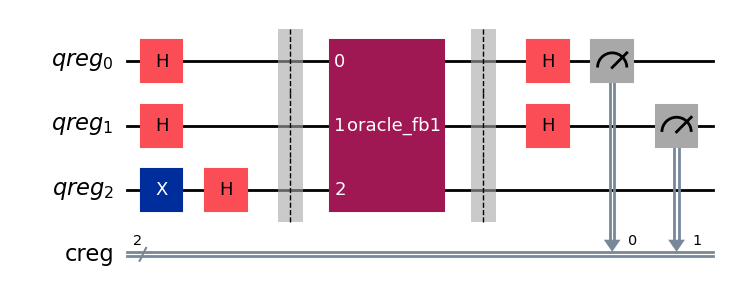

In [146]:
rqc = dj_circuit(n, ora2fb1)
display(rqc.draw('mpl'))

<IBMBackend('ibm_sherbrooke')>


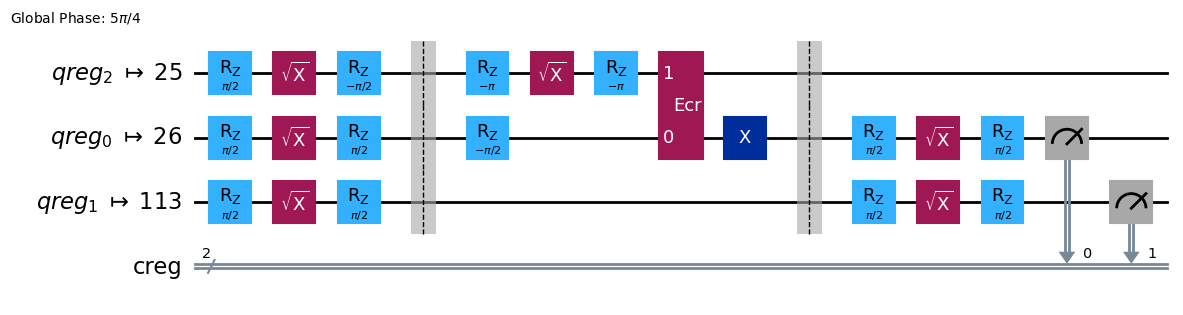

In [147]:
isa_circuit, backend = transpile_circuit(rqc, name_backend = "ibm_sherbrooke", opt_level = 1)

display(isa_circuit.draw("mpl", idle_wires=False))

In [148]:
result = run_circuit(isa_circuit, backend, 1000)

job id: czzx2ykqnmvg008wbx0g


{'00': 12, '01': 976, '11': 12}


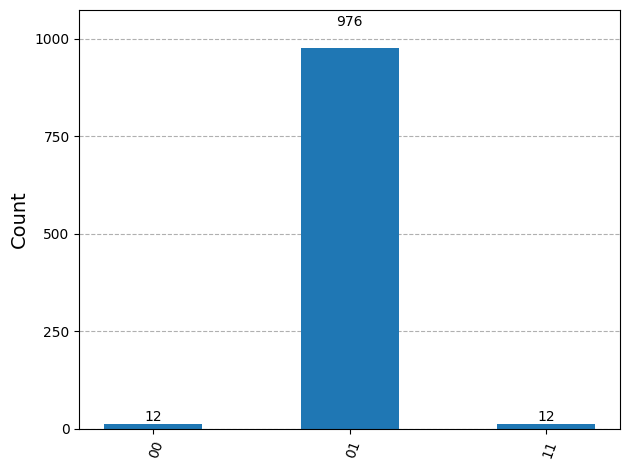

In [149]:
show_result(result)

En este caso tenemos la función $f_{b1_{2bits}}$ el cual es una función balanceada que devuelve 1 cuando el bit menos significativo de la entrada es 1.\
Aplicando el algoritmo de D.J. con el oráculo diseñado para esta función deberíamos medir mayoritariamente un valor distinto de 0, que es lo que hemos obtenido tal y como se ve en el gráfico. Los errores son bastante pequeños y por eso podemos despreciarlos 

### $f_{b2_{2bits}}$

In [112]:
n = 2

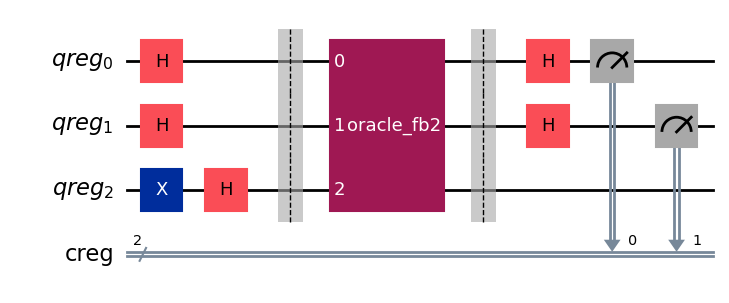

In [113]:
rqc = dj_circuit(n, ora2fb2)
display(rqc.draw('mpl'))

<IBMBackend('ibm_sherbrooke')>


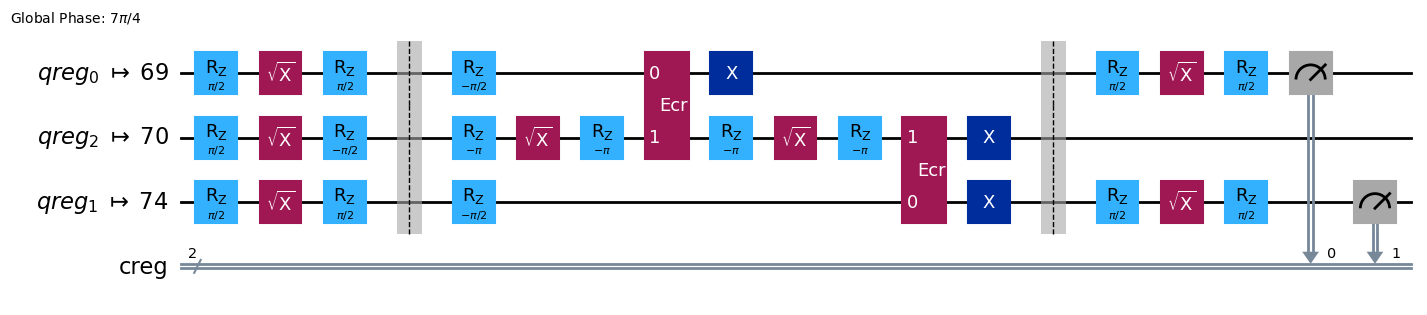

In [114]:
isa_circuit, backend = transpile_circuit(rqc, name_backend = "ibm_sherbrooke", opt_level = 1)

display(isa_circuit.draw("mpl", idle_wires=False))

In [115]:
result = run_circuit(isa_circuit, backend, 1000)

job id: czzwcpjqnmvg008wbs50


{'10': 22, '11': 963, '01': 11, '00': 4}


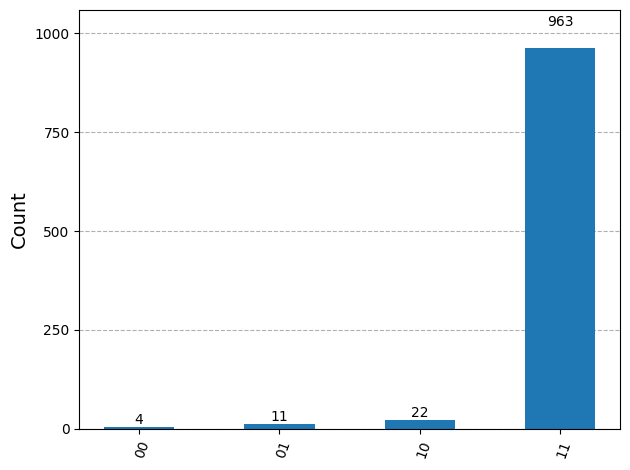

In [116]:
show_result(result)

En este caso tenemos la función balanceada de 2 bits de entrada $f_{b2_{2bits}}$ que devolvía 1 por la salida para las entradas $00_2$ y $11_2$.\
Al ser una función balanceada, al aplicarle el algoritmo de D.J. debería devolver al medir un valor diferente a 0.\
En nuestro caso obtenemos en la medición mayoritariamente $11_2$ con algunos errores (incluso en el 0) pero son muy pequeños. Podemos afirmar que ha funcionado el circuito y se puede ver con tan solo 1000 shots.

Este al ser un circuito pequeñito el ruido del computador cuántico real no afectaría mucho a los estados y por eso tenemos unas salidas tan "limpias". Veamos qué va pasando cuando aumentamos la complejidad.

### $f_{1_{3bits}}$

In [107]:
n = 3

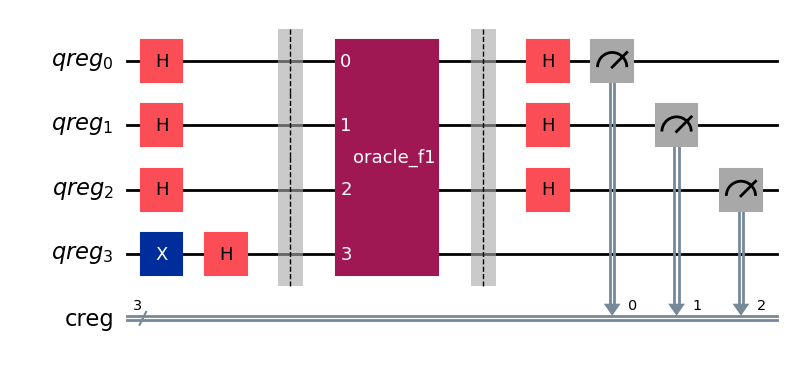

In [108]:
rqc = dj_circuit(n, ora3f1)
display(rqc.draw('mpl'))

<IBMBackend('ibm_sherbrooke')>


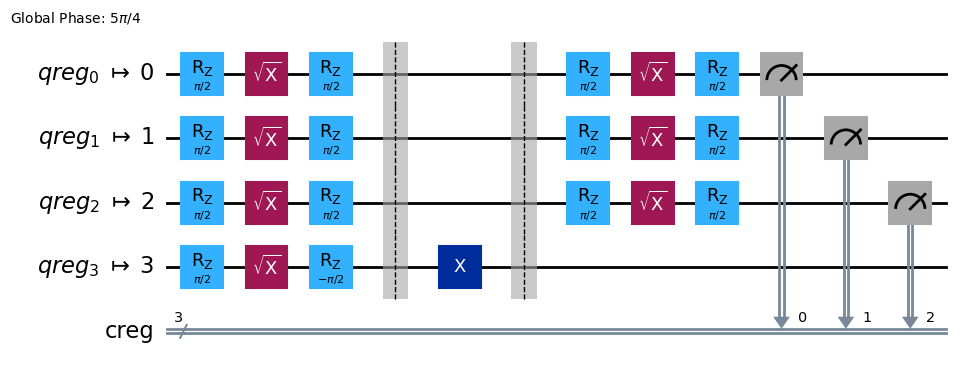

In [109]:
isa_circuit, backend = transpile_circuit(rqc, name_backend = "ibm_sherbrooke", opt_level = 1)

display(isa_circuit.draw("mpl", idle_wires=False))

In [110]:
result = run_circuit(isa_circuit, backend, 1000)

job id: czzw9gyrxz8g008fe14g


{'000': 869, '010': 97, '100': 26, '110': 4, '001': 3, '011': 1}


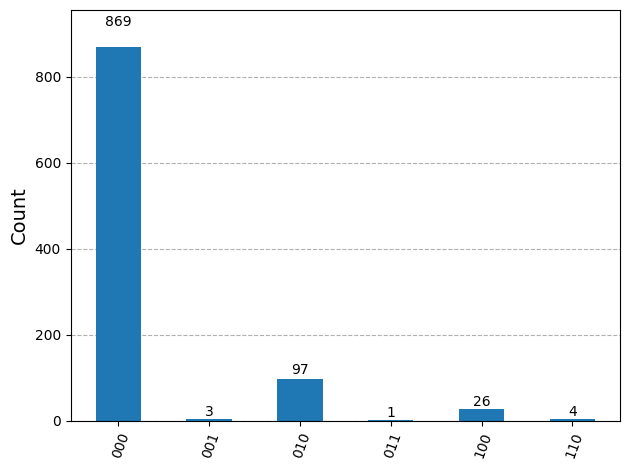

In [111]:
show_result(result)

$f_{1_{3bits}}$ era una funcion constante que sin importar la entrada devolvía 1 por la salida. Al aplicar el algoritmo de Deutsch-Jozsa sobre para determinar qué tipo de función es nos debería salir 0.\
Como se ve en el gráfico, al ejecutarlo en un computador real hemos obtenido 0 (mayoritariamente) con algunos errores que ya son cosa del problema del computador cuántico.

### $f_{b1_{3bits}}$ 

In [125]:
n = 3

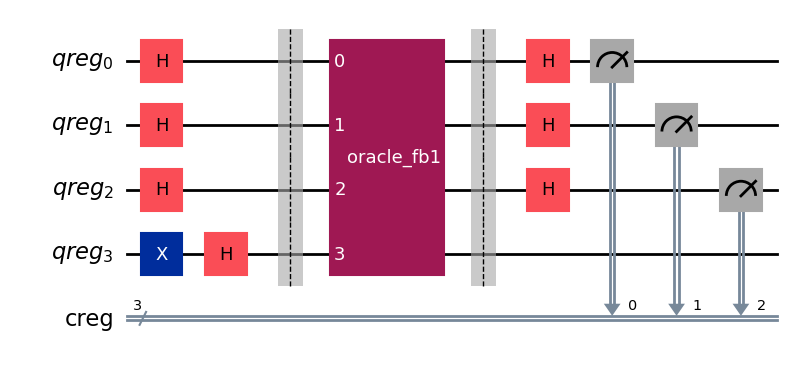

In [126]:
rqc = dj_circuit(n, ora3fb1)
display(rqc.draw('mpl'))

<IBMBackend('ibm_sherbrooke')>


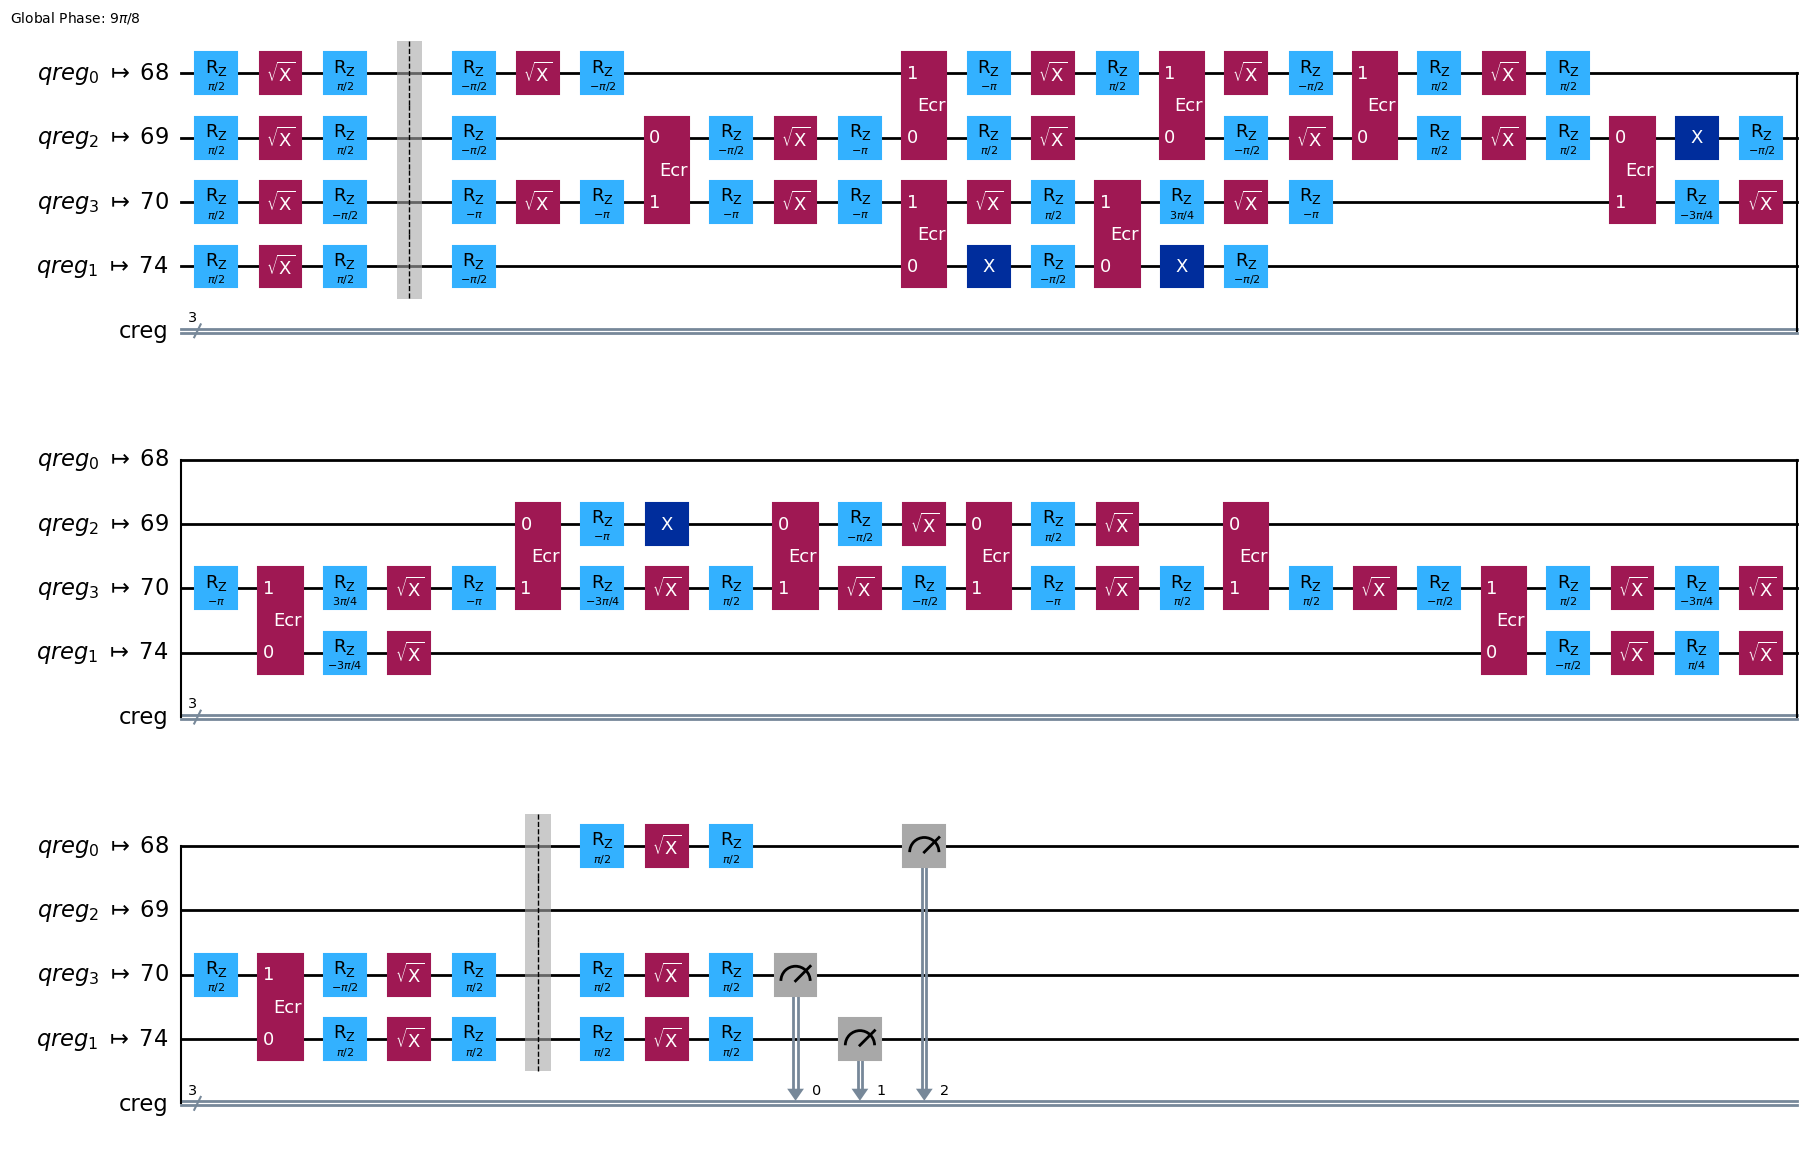

In [127]:
isa_circuit, backend = transpile_circuit(rqc, name_backend = "ibm_sherbrooke", opt_level = 1)

display(isa_circuit.draw("mpl", idle_wires=False))

In [128]:
result = run_circuit(isa_circuit, backend, 1000)

job id: czzwr5gd8drg008j56e0


{'001': 16, '111': 207, '101': 269, '100': 246, '110': 236, '000': 10, '011': 11, '010': 5}


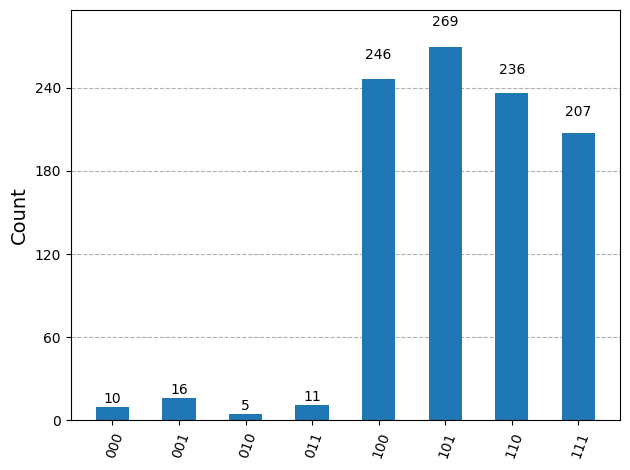

In [129]:
show_result(result)

En este caso tenemos la función balanceada $f_{b1_{3bits}}$, que es el que aparece aparece en los apuntes del algoritmo de Deutsch-Jozsa.

Se puede observar que obtenemos varias medidas mayoritariamente en los valores 100 101 110 y 111. Esto nos indica que es una función balanceada pues no ha medido 0 mayoritariamente.\
A pesar de todo tenemos algunas mediciones que han colapsado en 0, pero al ser tan pocos, podemos relacionarlo con el ruido y los errores del computador cuántico.

### $f_{b2_{3bits}}$ 

In [132]:
n = 3

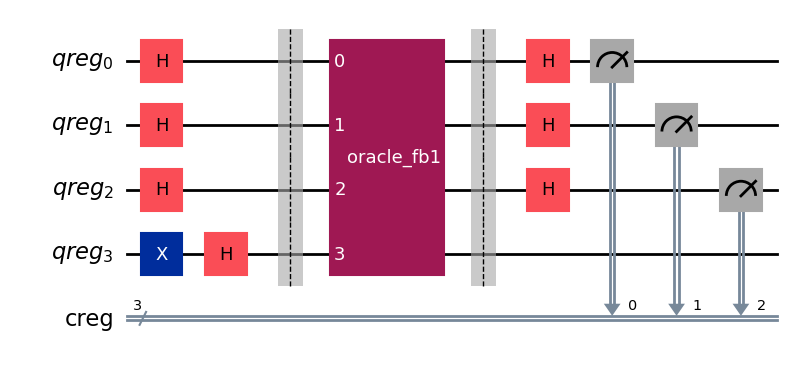

In [133]:
rqc = dj_circuit(n, ora3fb2)
display(rqc.draw('mpl'))

Transpilamos el circuito

<IBMBackend('ibm_sherbrooke')>


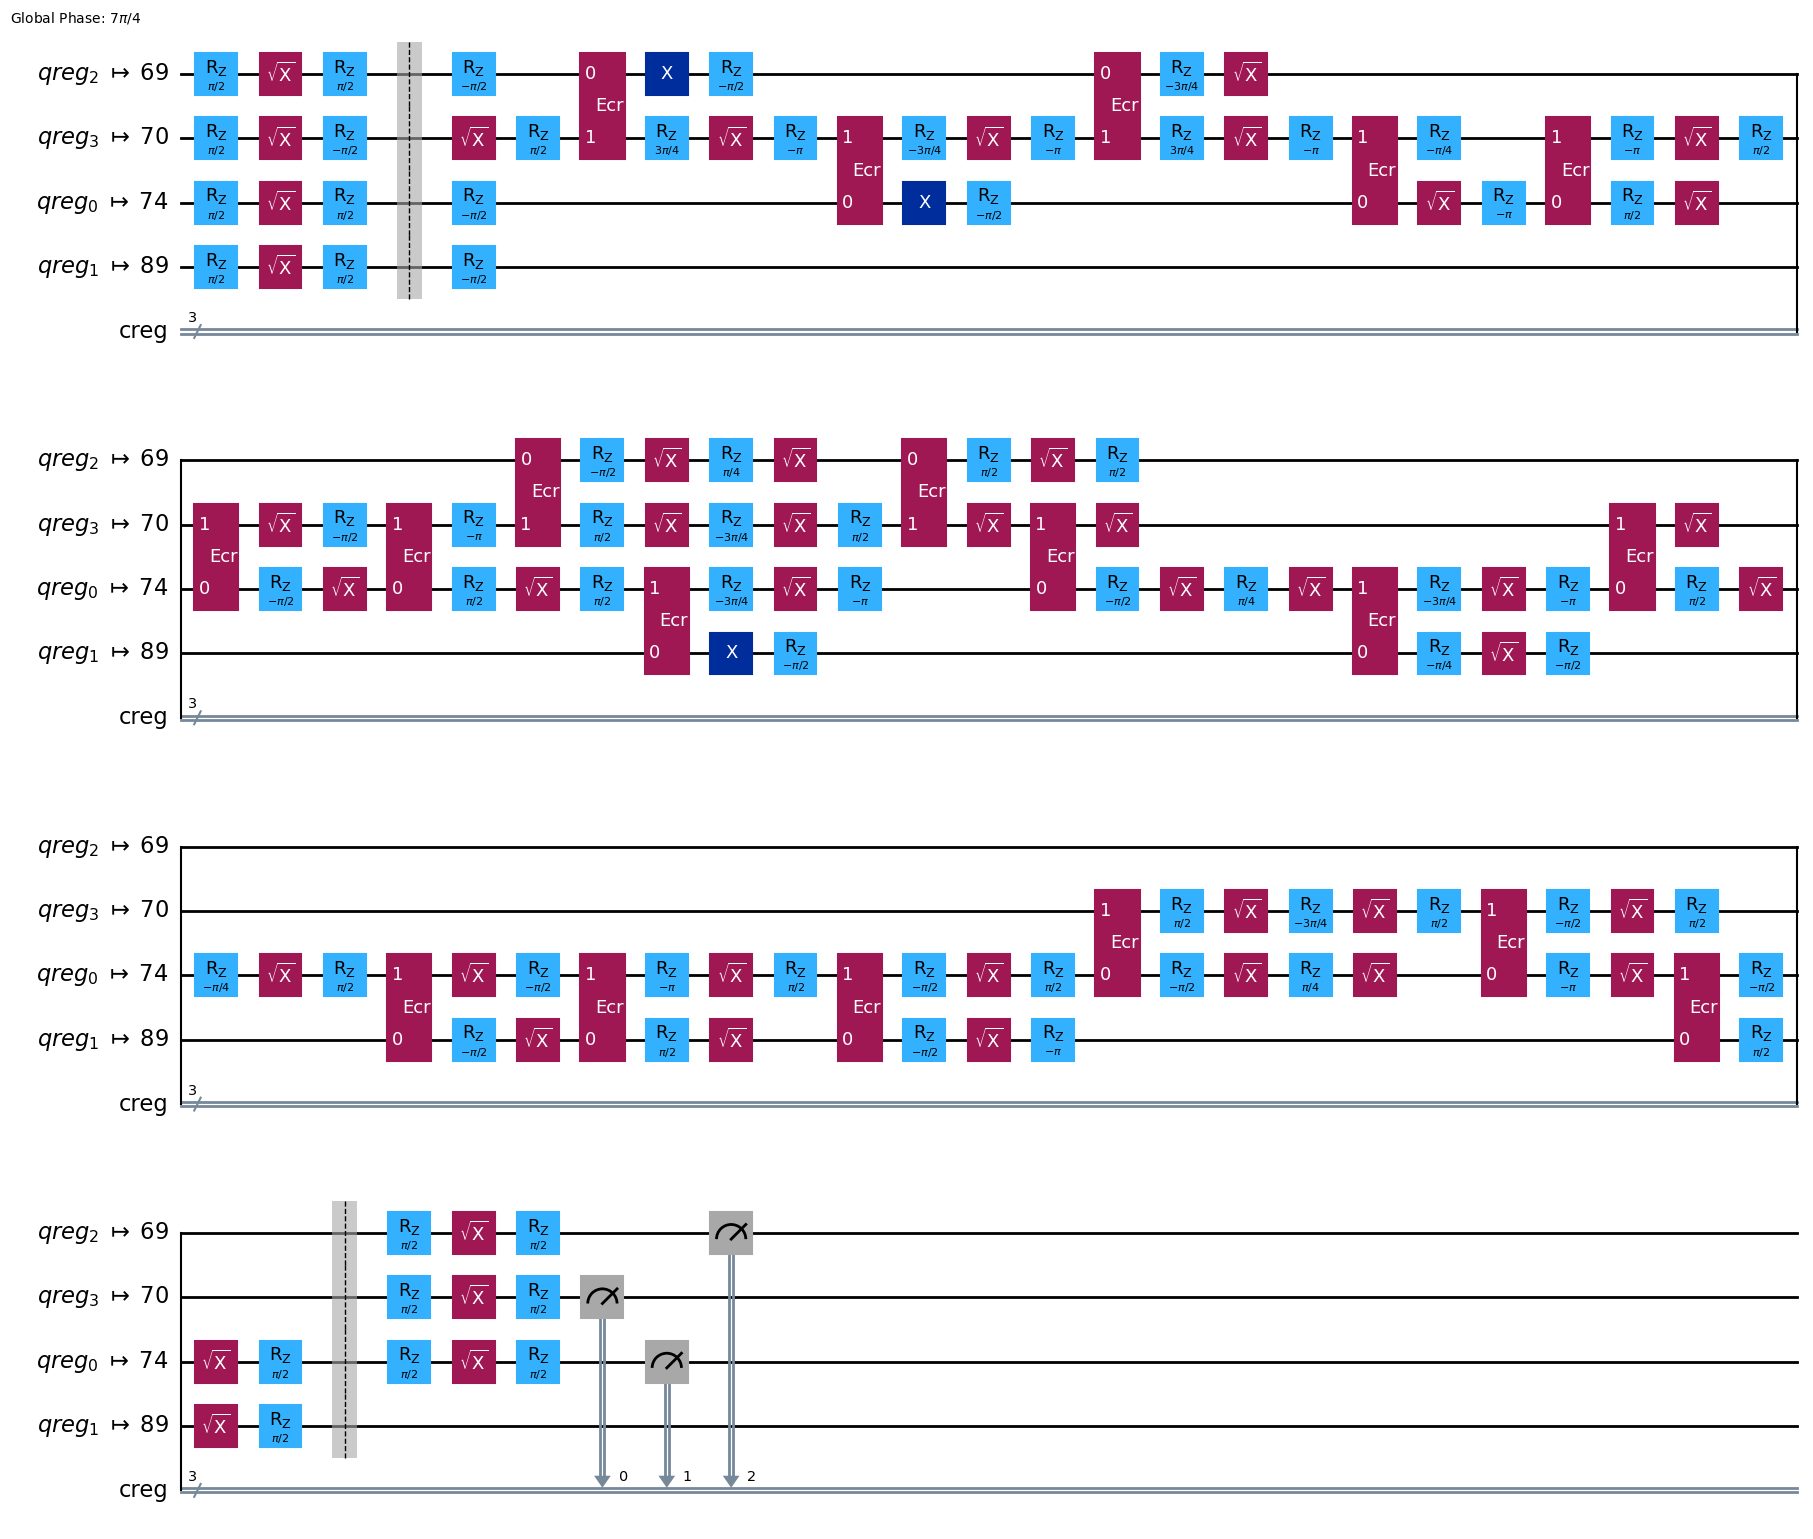

In [137]:
isa_circuit, backend = transpile_circuit(rqc, name_backend = "ibm_sherbrooke", opt_level = 1)

display(isa_circuit.draw("mpl", idle_wires=False))

Ejecutamos el circuito

In [138]:
result = run_circuit(isa_circuit, backend, 1000)

job id: czzwwdhqnmvg008wbvkg


Mostramos los resultados

{'001': 75, '101': 231, '111': 50, '011': 164, '010': 227, '100': 164, '110': 51, '000': 38}


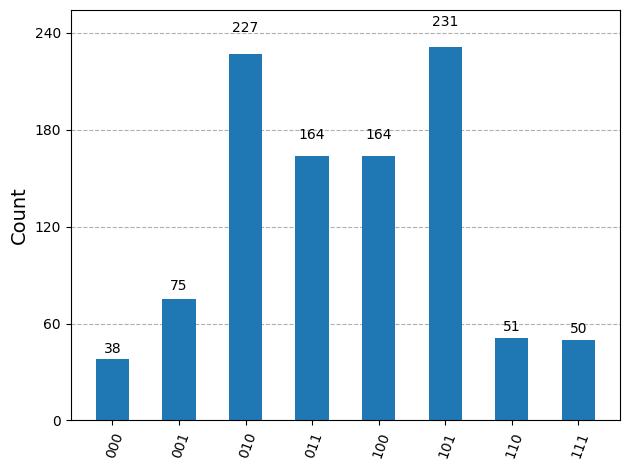

In [139]:
show_result(result)

Tenemos en este caso la función $f_{b2_{3bits}}$ que es balanceada.\
En la simulacion hemos obtenido que todas las medidas han colapsado en 010, 011, 100 y 101.\
Observando el gráfico tras ejecutarlo en un computador real vemos que la gran mayoría de las mediciones también han caído en esos valores, pero esta vez con algunos errores otros valores como el 0.\
No obstante, al caer la mayoría en valores distinto de 0 podemos concluir que se ha demostrado de manera satisfactoria que la función es balanceada.

### $f_{b1_{4bits}}$

In [140]:
n = 4


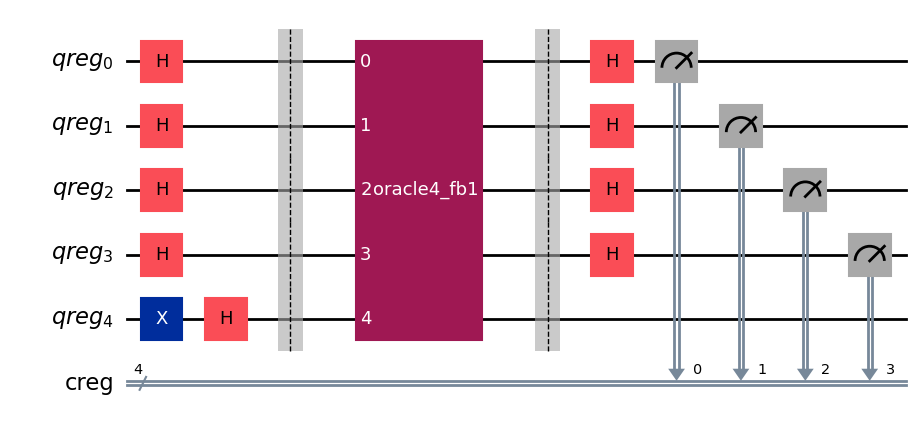

In [141]:
rqc = dj_circuit(n, ora4fb1)
display(rqc.draw('mpl'))

<IBMBackend('ibm_sherbrooke')>


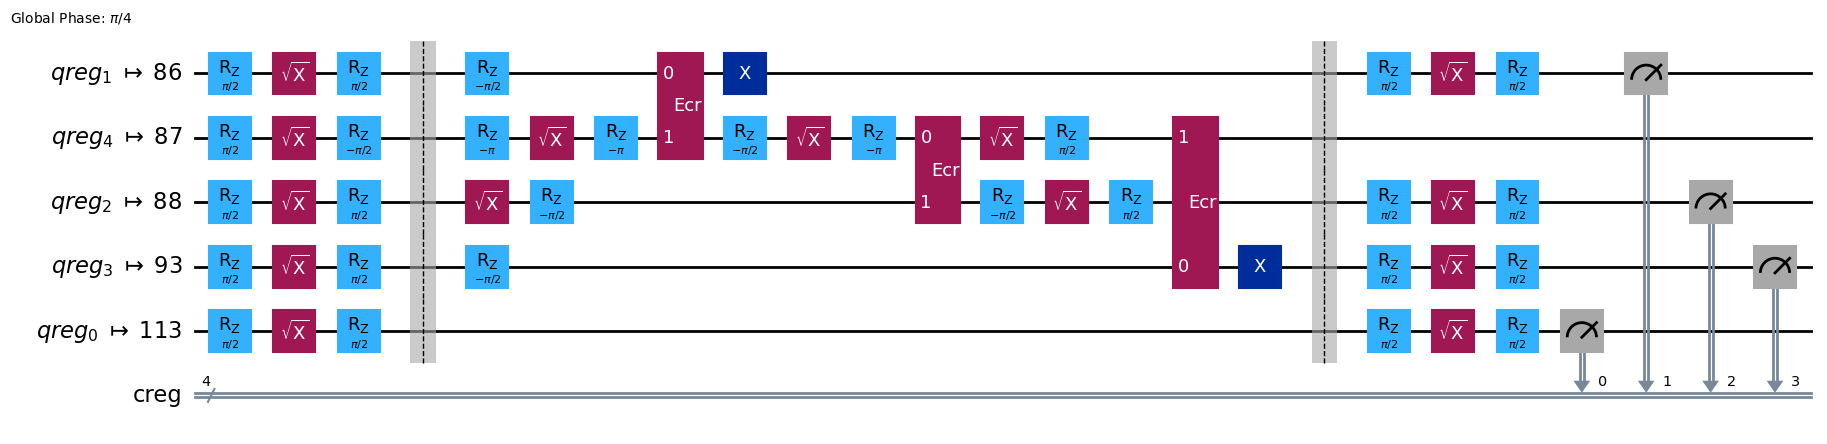

In [142]:
isa_circuit, backend = transpile_circuit(rqc, name_backend = "ibm_sherbrooke", opt_level = 1)

display(isa_circuit.draw("mpl", idle_wires=False))

In [143]:
result = run_circuit(isa_circuit, backend, 1000)

job id: czzwz2md8drg008j57p0


{'0100': 1, '1110': 876, '1100': 20, '1010': 33, '1111': 33, '0110': 25, '0000': 9, '1101': 1, '0010': 2}


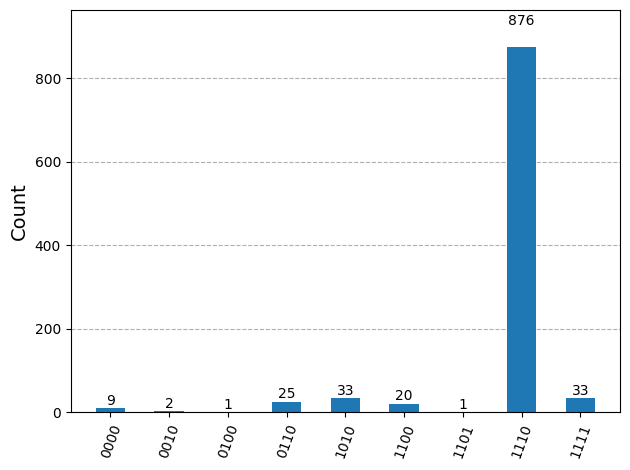

In [144]:
show_result(result)

La funcion $f_{b1_{4bits}}$ también es balanceada y al ejecutarlo en el computador cuántico real de IBM hemos obtenido lo que se observa en el gráfico anterior.

La mayoría de la mediciones en un solo estado que es el 1110, el cual es distinto de 0. Podemos concluir que el circuito ha funcionado correctamente y ha demostrado de manera satisfactoria que la función es balanceada. 

### $f_{b2_{4bits}}$

In [117]:
n = 4

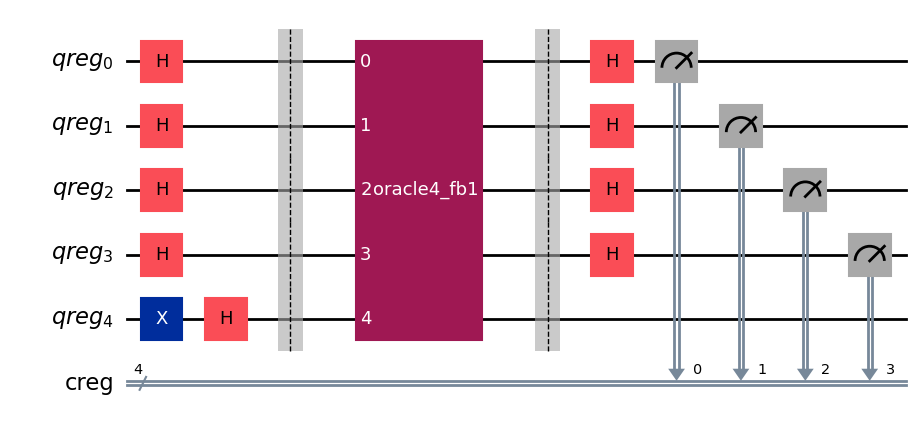

In [118]:
rqc = dj_circuit(n, ora4fb2)
display(rqc.draw('mpl'))

<IBMBackend('ibm_sherbrooke')>


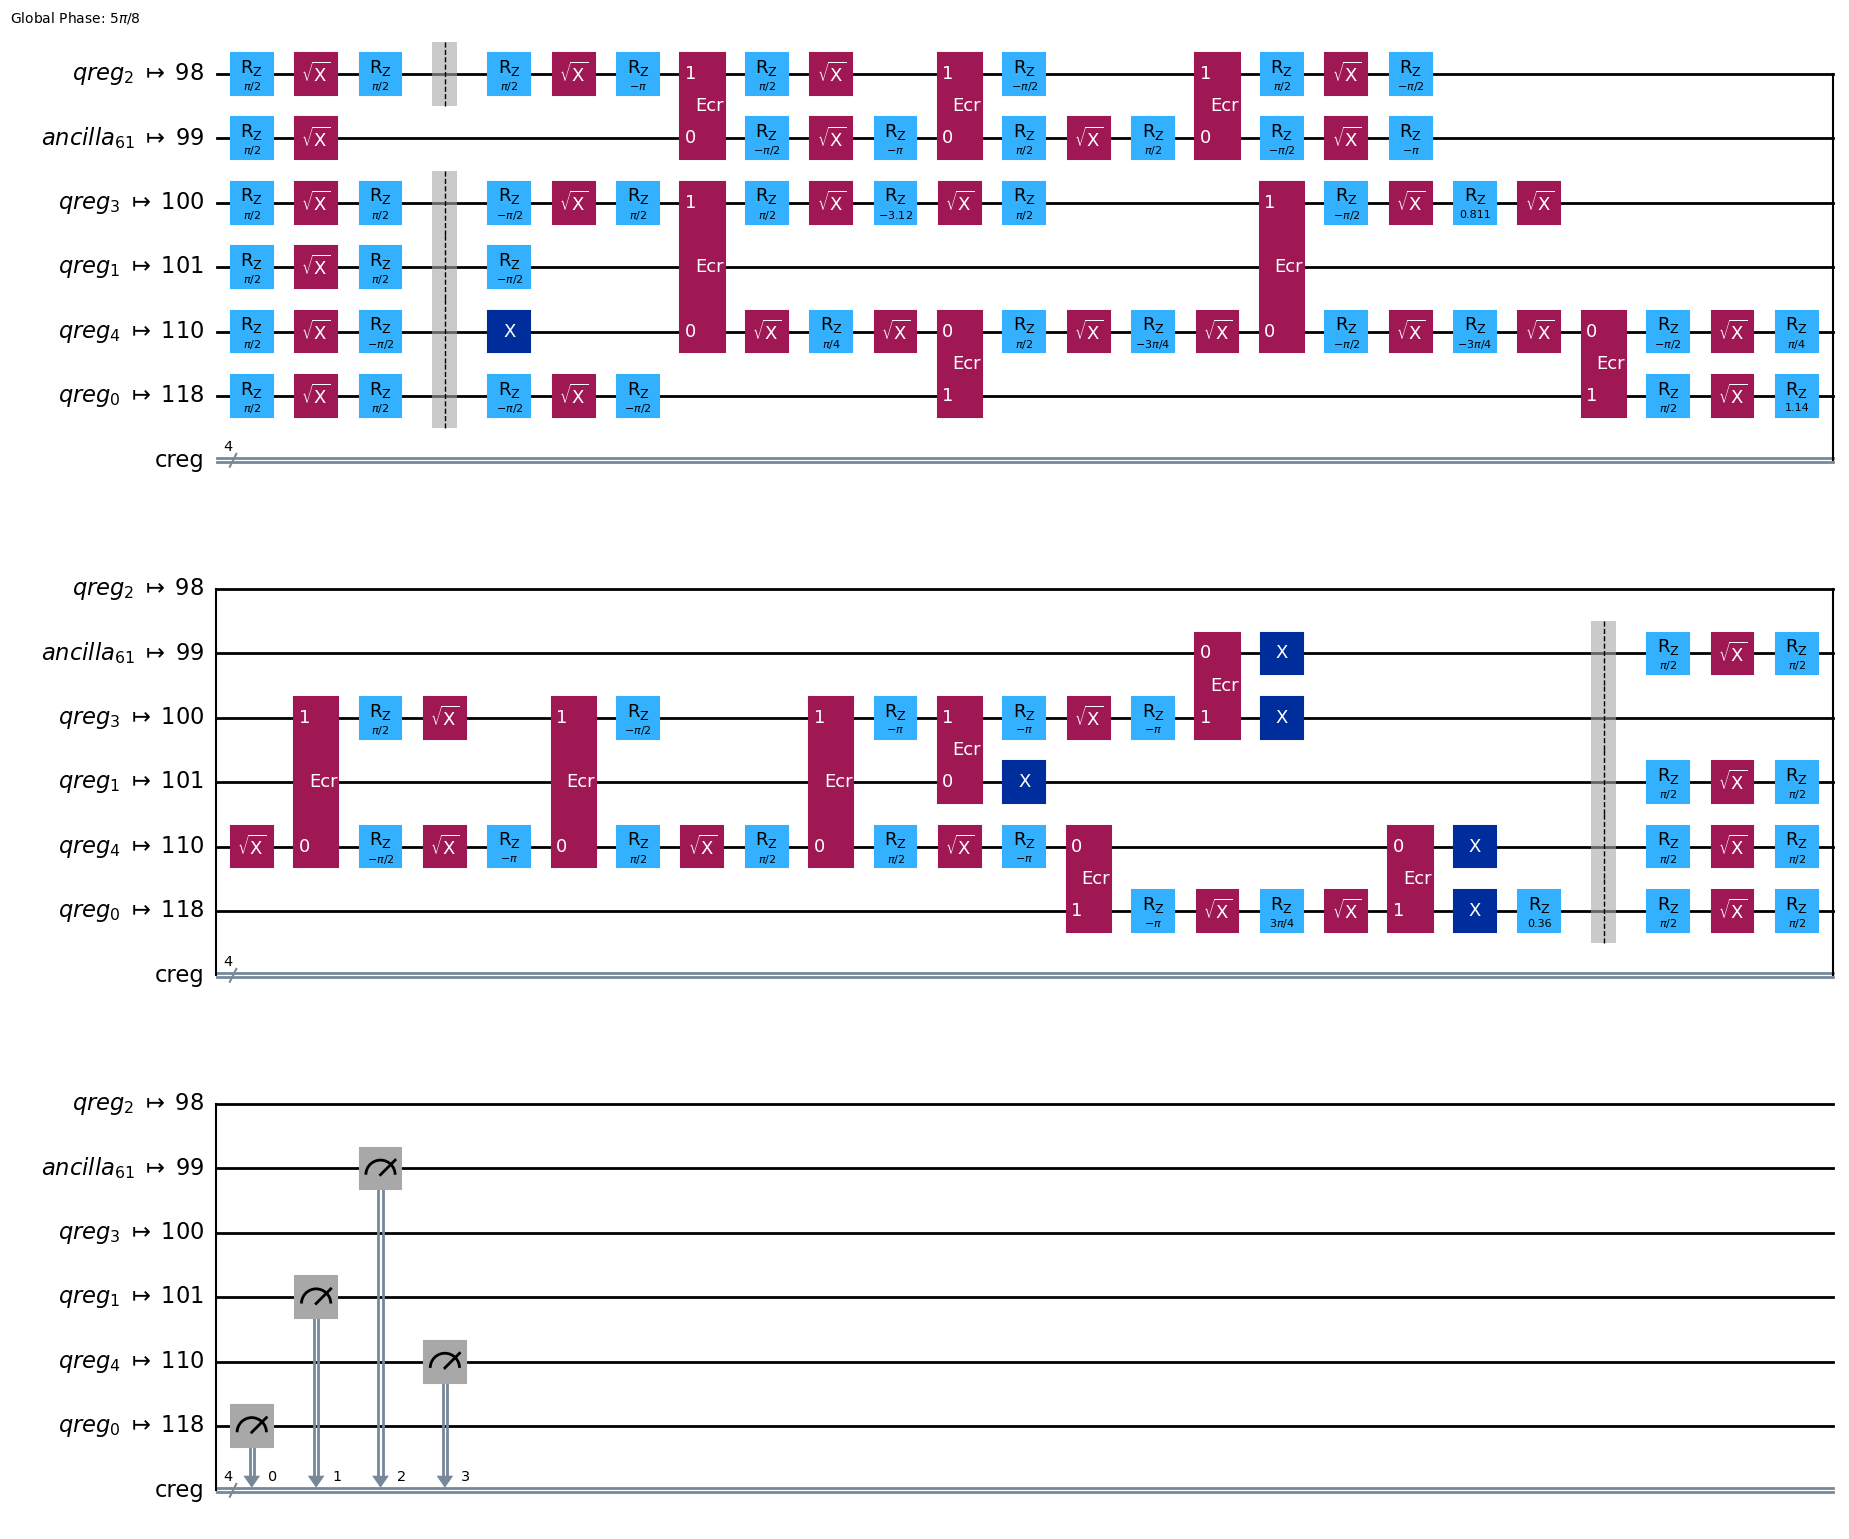

In [122]:
isa_circuit, backend = transpile_circuit(rqc, name_backend = "ibm_sherbrooke", opt_level = 2)

display(isa_circuit.draw("mpl", idle_wires=False))

In [123]:
result = run_circuit(isa_circuit, backend, 1000)

job id: czzwh9dd8drg008j55k0


{'1100': 17, '0110': 144, '1111': 202, '0111': 210, '0010': 16, '1001': 9, '0001': 19, '1000': 33, '1010': 25, '1110': 134, '0100': 58, '0011': 25, '0101': 49, '1011': 22, '1101': 21, '0000': 16}


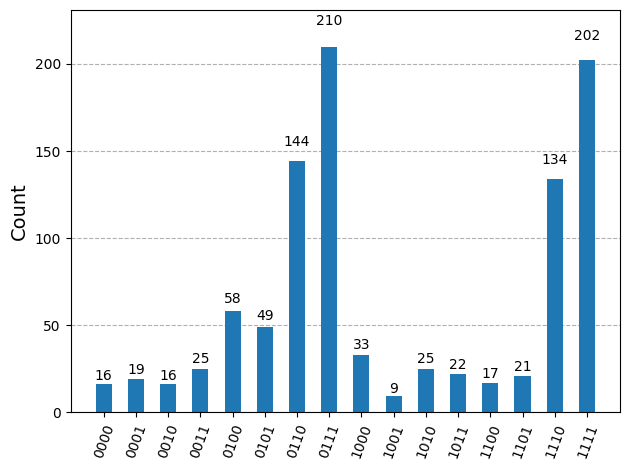

In [124]:
show_result(result)

La función $f_{b2_{4bits}}$ es una función balanceada que devuelve 1 por la salida en los valores que se indica en el ejercicio 1.

Para este caso donde el estado final no es un solo estado propio, sino una superposición de 4 estados (tal y como hemos visto en la simulación) es más facil obtener mediciones tan variadas.\
Para transpilar he usado el nivel 2 de optimización del circuito para que la salida salga mejor. Al principio lo había probado con un nivel 1 de optimización y no he obtenido muy buenos resultados.\
Como se puede ver en el gráfico, las medidas mayoritarias son valores distintos de 0 lo que queda claro que es una función balanceada. Se puede observar que hay bastantes más errores que en casos anteriores debido a que el circuito es algo más largo y complejo.

### $f_{a2_{4bits}}$
Esta es la funcion no constante ni balanceada.

In [179]:
n = 4

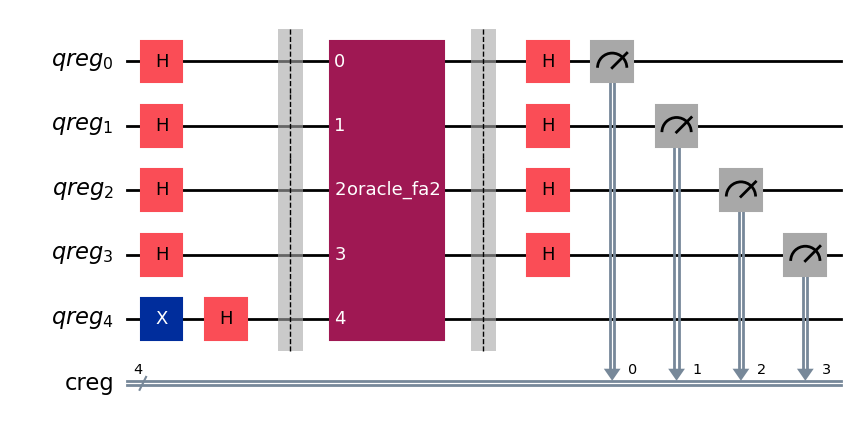

In [180]:
rqc = dj_circuit(n, ora4fa2)
display(rqc.draw('mpl'))

<IBMBackend('ibm_sherbrooke')>


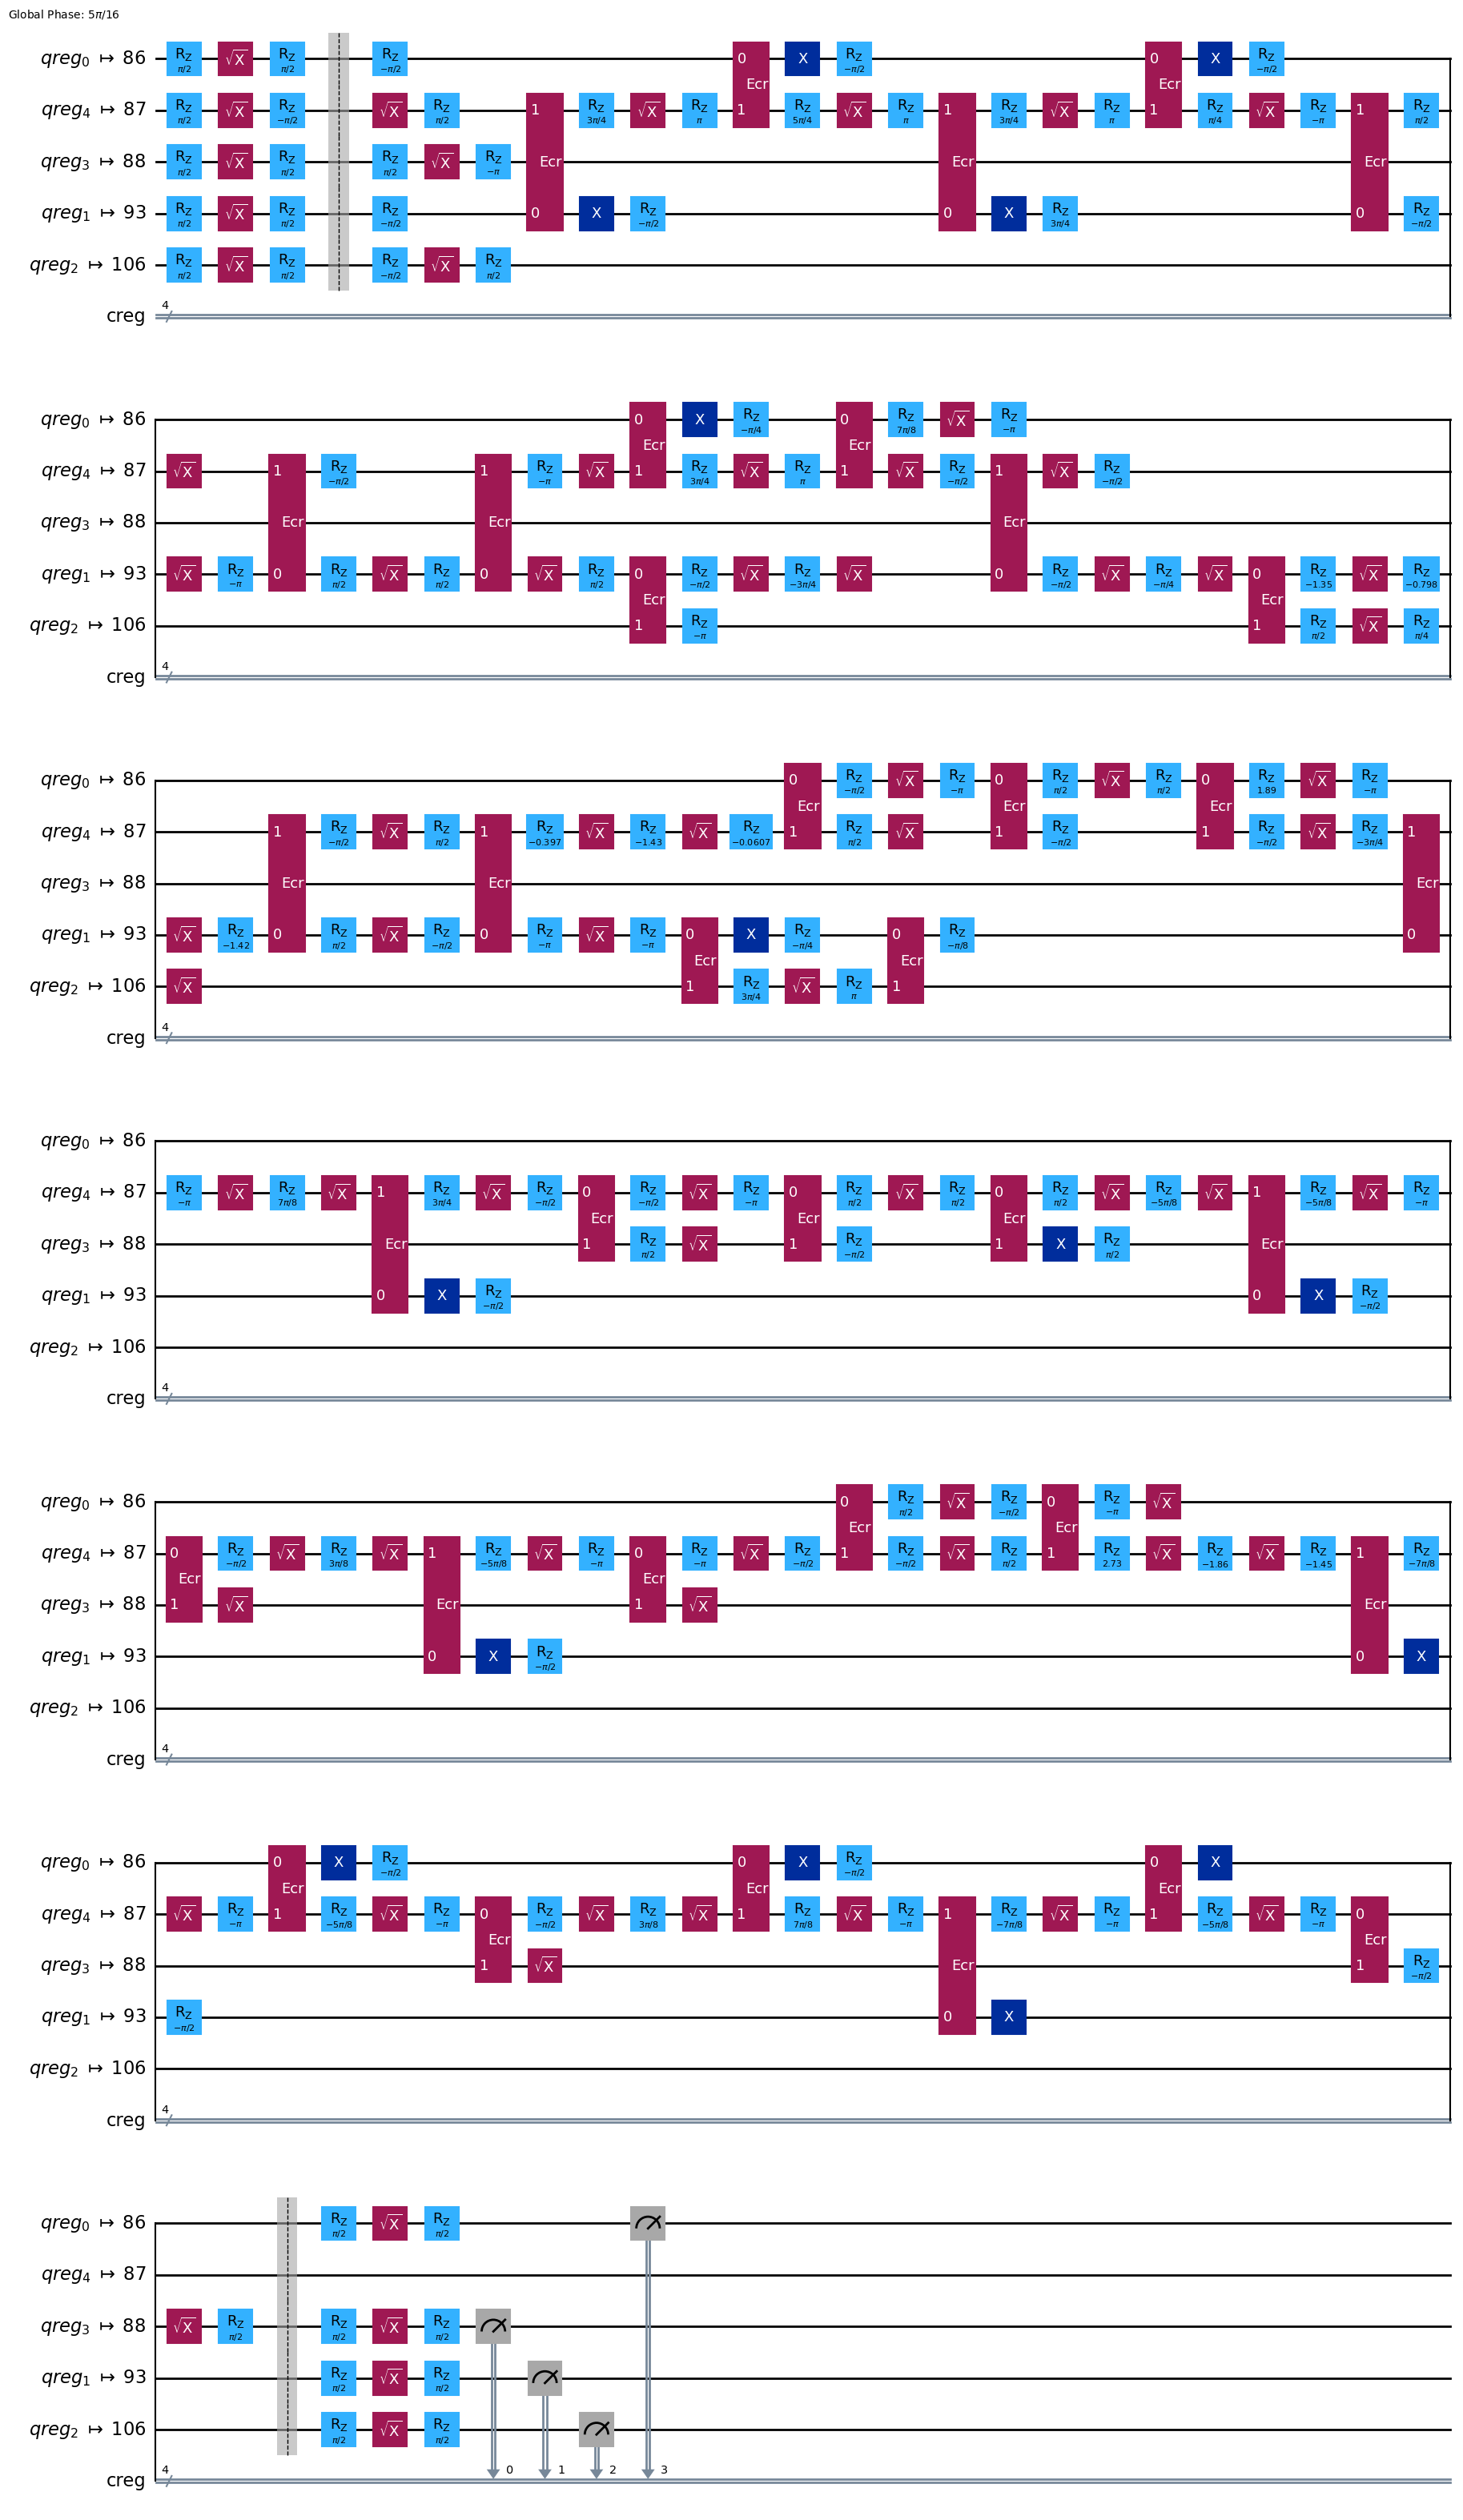

In [194]:
isa_circuit, backend = transpile_circuit(rqc, name_backend = "ibm_sherbrooke", opt_level = 2)

display(isa_circuit.draw("mpl", idle_wires=False))

In [195]:
result = run_circuit(isa_circuit, backend, 10000)

job id: czzyshyqnmvg008wc9zg


{'1101': 379, '0001': 347, '0010': 558, '0011': 589, '1011': 1204, '1110': 654, '1001': 382, '0110': 403, '1000': 921, '0000': 1014, '1100': 733, '0100': 671, '1010': 839, '0111': 377, '0101': 303, '1111': 626}


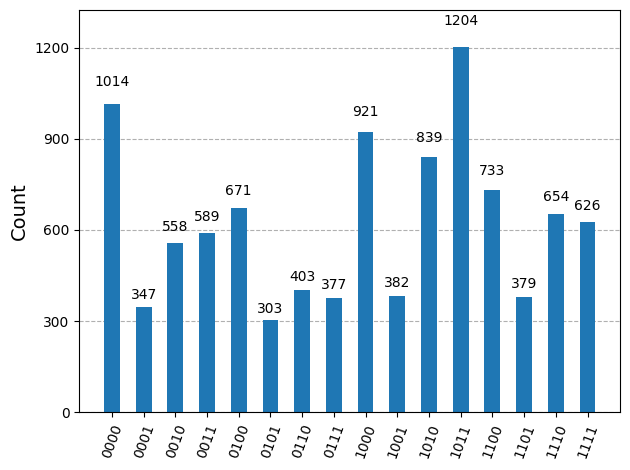

In [196]:
show_result(result)

Tras ejecutar el algoritmo para esta funcion que no es ni balanceada ni constante, obtenemos el siguiente gráfico.\
Entre las medidas que más se han obtenido al colapsar los qubits, entre otros, $\ket{0}$, $\ket{8}$,$\ket{9}$ y $\ket{10}$.\
Es decir, el estado final que obtenemos es una superposición de posiblemente estos estados y puede que otros más (ver simulación). No obstante, lo que nos interesa es que se llega a medir $\ket{0}$ tantas veces junto a otros valores, lo que nos demuestra que la función no es ni balanceada ni constante. 

Entonces, la ejecución en el backend real también ha funcionado el algoritmo tal y como se esperaba (aunque tras muchas ejecuciones, con 10.000 y nivel de optimización al transpilar de nivel 2).